# App Reviews AI - Enhanced Analysis Dashboard

This notebook demonstrates how to use the App Reviews AI system to analyze app reviews from the Google Play Store and generate a comprehensive, insightful dashboard that's ready to share with stakeholders.

## What's Included in the Enhanced Dashboard

This notebook creates a fully comprehensive analysis dashboard that includes:

1. **Interactive Visualizations**
   - Rating distributions with trend analysis
   - Sentiment analysis with distribution charts
   - Topic modeling with detailed topic breakdowns
   - Version-based analysis showing performance across app versions
   - Keyword analysis and importance rankings

2. **Explanatory Elements**
   - Detailed explanations for each visualization
   - Interpretation guidance for all metrics
   - Context for why each chart matters and how to use the insights

3. **Tabular Insights**
   - Comprehensive metrics tables by version
   - Topic details with representative keywords
   - Keyword importance heatmaps
   - Performance comparison across versions

4. **AI-Generated Insights**
   - Critical issues identification
   - User pain points categorization
   - Quick win opportunities
   - Strengths to build upon
   - Version-specific findings

This enhanced dashboard provides a complete picture of app performance based on user reviews, with actionable insights that product managers, developers, and executives can use to drive improvements.

## Options for Review Data

This notebook provides multiple options for working with review data:

1. **Fetch new reviews** from the Google Play Store API
2. **Load existing reviews** from CSV storage
3. **Retrieve reviews** from the vector database
4. **Generate mock data** as a fallback

This flexible approach allows you to run the analysis without repeatedly making API calls, which conserves API quotas and speeds up the workflow when iterating on the analysis.

# Setup

First, let's set up the environment and import the necessary modules.

In [27]:
# Import required libraries
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv

# Add the project root to the path so we can import our modules
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")

# Load environment variables from .env file
load_dotenv()

# Check if OpenAI API key is available
if not os.environ.get("OPENAI_API_KEY"):
    print("⚠️ WARNING: OPENAI_API_KEY not found in environment variables. Some features may not work.")

## Initialize the Runner

Now let's import and initialize our review analysis runner.

In [28]:
# Ensure all required directories exist
import os
os.makedirs(os.path.join('..', 'logs'), exist_ok=True)
os.makedirs(os.path.join('..', 'data'), exist_ok=True)
os.makedirs(os.path.join('..', 'reports'), exist_ok=True)

from src.runner import ReviewAnalysisRunner

# Initialize the runner
runner = ReviewAnalysisRunner()

# Initialize the modules
runner._initialize_modules()

2025-05-08 19:15:55,767 - app_reviews - INFO - Initializing modules...
2025-05-08 19:15:55,769 - app_reviews - INFO - Initializing acquisition module...
Acquisition module using APP_ID from environment: com.fss.indus
2025-05-08 19:15:55,769 - app_reviews - INFO - Using app ID: com.fss.indus
2025-05-08 19:15:55,770 - app_reviews - INFO - Using MAX_REVIEWS from environment: 5000
2025-05-08 19:15:56,061 - app_reviews - INFO - Initializing storage module...
Initialize: Using default file path: /Users/dipesh/Local-Projects/indigo-reviews-ai/src/data/reviews.csv
2025-05-08 19:15:56,068 - app_reviews - INFO - Initializing preprocessor module...
2025-05-08 19:15:56,070 - app_reviews - INFO - Initializing analyzer module...
2025-05-08 19:15:56,078 - app_reviews - INFO - Initializing vector database module...
DEBUG: Vector DB checking USE_MOCK_DATA: 'false'
Using OpenAI embedding function for real data mode
Clearing existing collection: app_reviews
Creating new collection: app_reviews
2025-05-08

2025-05-08 19:15:57,917 - urllib3.connectionpool - WARNING - Retrying (Retry(total=1, connect=1, read=2, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x1585079d0>: Failed to resolve 'us.i.posthog.com' ([Errno 8] nodename nor servname provided, or not known)")': /batch/
2025-05-08 19:15:57,921 - urllib3.connectionpool - WARNING - Retrying (Retry(total=0, connect=0, read=2, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x1580e0110>: Failed to resolve 'us.i.posthog.com' ([Errno 8] nodename nor servname provided, or not known)")': /batch/
2025-05-08 19:15:57,925 - backoff - INFO - Backing off send_request(...) for 0.9s (requests.exceptions.ConnectionError: HTTPSConnectionPool(host='us.i.posthog.com', port=443): Max retries exceeded with url: /batch/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x1530c4c

## Fetch or Load App Reviews

You can either fetch new reviews from the Google Play Store or load existing reviews from storage.
Choose one of the options below based on your needs.

In [29]:
# Option 1: Fetch new reviews from Google Play Store
# Uncomment this section to fetch fresh reviews

# app_id = "com.example.app"  # Example mobile app ID
# start_date = "6 months ago"  # Fetch reviews from 6 months ago
# end_date = "now"             # Up to today
# max_reviews = 1000           # Limit to 1000 reviews for demonstration purposes

# reviews_df = runner.fetch_reviews(
#     app_id=app_id,
#     start_date=start_date,
#     end_date=end_date,
#     max_reviews=max_reviews
# )

# Make sure data directory exists
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
data_dir = os.path.join(project_root, 'data')
processed_data_dir = os.path.join(data_dir, 'processed')
os.makedirs(data_dir, exist_ok=True)
os.makedirs(processed_data_dir, exist_ok=True)

# Temporarily disable mock mode for data loading
original_mock_value = os.environ.get("USE_MOCK_DATA", "")
os.environ["USE_MOCK_DATA"] = "false"

# Option 2: Load reviews from the processed data file
# This is useful to avoid making API calls and use the already processed data
use_processed_data = True  # Set to True to use processed data from data_preprocessing.ipynb
use_storage = not use_processed_data  # Fall back to storage only if not using processed data

reviews_df = None

if use_processed_data:
    # Direct load from the processed CSV file
    processed_csv_path = os.path.join(processed_data_dir, 'processed_reviews.csv')
    if os.path.exists(processed_csv_path):
        print(f"Loading processed reviews from: {processed_csv_path}")
        try:
            reviews_df = pd.read_csv(processed_csv_path)
            
            # Convert date column to datetime if it exists
            if 'date' in reviews_df.columns:
                reviews_df['date'] = pd.to_datetime(reviews_df['date'], errors='coerce')
                
            if reviews_df.empty:
                raise ValueError("Processed CSV file exists but contains no data")
                
            print(f"✅ Successfully loaded {len(reviews_df)} processed reviews from CSV file")
            
            # Check if this data already has sentiment and topics
            has_sentiment = 'sentiment' in reviews_df.columns
            has_topics = 'primary_topic' in reviews_df.columns
            
            print(f"Data status: has_sentiment={has_sentiment}, has_topics={has_topics}")
            
            # For numeric columns that might have been converted to strings, convert back
            numeric_columns = ['rating', 'primary_topic', 'topic_confidence', 'thumbsUpCount']
            for col in numeric_columns:
                if col in reviews_df.columns and reviews_df[col].dtype == 'object':
                    try:
                        reviews_df[col] = pd.to_numeric(reviews_df[col], errors='coerce')
                        print(f"Converted {col} to numeric type")
                    except:
                        print(f"Could not convert {col} to numeric type")
        except Exception as e:
            print(f"Error loading processed data: {e}")
            reviews_df = None
    else:
        print(f"❌ Processed CSV file not found at: {processed_csv_path}")
        print("Falling back to raw data...")
        use_storage = True

if use_storage and reviews_df is None:
    try:
        # Direct load from the CSV file to bypass storage module issues
        csv_path = os.path.join(project_root, 'data', 'reviews.csv')
        if os.path.exists(csv_path):
            print(f"Loading raw reviews from: {csv_path}")
            reviews_df = pd.read_csv(csv_path)
            
            # Convert date column to datetime if it exists
            if 'date' in reviews_df.columns:
                reviews_df['date'] = pd.to_datetime(reviews_df['date'], errors='coerce')
                
            if reviews_df.empty:
                raise ValueError("CSV file exists but contains no data")
                
            print(f"Successfully loaded {len(reviews_df)} reviews from raw CSV file")
        else:
            # Fall back to storage module
            print("CSV file not found, trying storage module...")
            reviews_df = runner.storage.retrieve_data()
            
            if reviews_df.empty:
                raise ValueError("No reviews found in storage")
            
            print(f"Successfully loaded {len(reviews_df)} reviews from storage")
    except Exception as e:
        print(f"Error loading from storage: {e}")
        reviews_df = None

# Option 3: Load reviews from Vector Database
# Try vector DB if storage failed
use_vector_db = (reviews_df is None)

if use_vector_db:
    try:
        print("Loading reviews from vector database...")
        
        # Force using the non-mock collection
        if hasattr(runner.vector_db, '_collection_name'):
            # Store the original collection name
            original_collection = runner.vector_db._collection_name
            
            # Use the non-mock collection name
            if original_collection.endswith('_mock'):
                real_collection = original_collection.replace('_mock', '')
            else:
                real_collection = original_collection
                
            print(f"Switching from {original_collection} to {real_collection}")
            runner.vector_db._collection_name = real_collection
            
            # Re-initialize collection with new name
            runner.vector_db._collection = runner.vector_db._client.get_collection(
                name=real_collection,
                embedding_function=runner.vector_db._embedding_function
            )
        
        # Get vector DB stats
        stats = runner.vector_db.get_collection_stats()
        print(f"Vector DB collection: {stats['collection_name']}")
        print(f"Document count: {stats['document_count']}")
        
        if stats['document_count'] == 0:
            raise ValueError("No documents found in vector database")
            
        # Create a query that matches everything (we'll limit results)
        all_docs = []
        batch_size = 100
        total_batches = (stats['document_count'] + batch_size - 1) // batch_size
        
        for i in range(total_batches):
            # Use a different query for each batch to avoid duplicate results
            query = f"reviews batch {i+1}"
            batch_results = runner.vector_db.search(
                query=query,
                n_results=min(batch_size, stats['document_count'] - i*batch_size)
            )
            all_docs.extend(batch_results)
            print(f"Retrieved batch {i+1}/{total_batches} ({len(batch_results)} documents)")
        
        # Convert to DataFrame
        vector_df = pd.DataFrame(all_docs)
        
        # Process to match expected format
        if 'id' in vector_df.columns and 'review_id' not in vector_df.columns:
            vector_df = vector_df.rename(columns={'id': 'review_id'})
        
        # Convert date columns if needed
        if 'date' in vector_df.columns and not pd.api.types.is_datetime64_dtype(vector_df['date']):
            vector_df['date'] = pd.to_datetime(vector_df['date'], errors='coerce')
        
        reviews_df = vector_df
        print(f"Successfully loaded {len(reviews_df)} reviews from vector database")
    except Exception as e:
        print(f"Error loading from vector database: {e}")
        reviews_df = None
        
    # Reset collection name if we changed it
    if use_vector_db and hasattr(runner.vector_db, '_collection_name') and 'original_collection' in locals():
        runner.vector_db._collection_name = original_collection
        # Re-initialize original collection
        try:
            runner.vector_db._collection = runner.vector_db._client.get_collection(
                name=original_collection,
                embedding_function=runner.vector_db._embedding_function
            )
            print(f"Restored original collection: {original_collection}")
        except Exception as e:
            print(f"Warning: Could not restore original collection: {e}")

# Option 4: Use mock data if all else fails
if reviews_df is None:
    print("Falling back to mock data...")
    
    # Generate mock data
    from datetime import datetime, timedelta
    import numpy as np
    
    # Create 100 mock reviews
    mock_reviews = []
    now = datetime.now()
    
    # Sample text content for app reviews
    sample_texts = [
        "Really smooth experience using this app. Love how fast and easy it is to navigate.",
        "App kept crashing during important tasks. Had to eventually use the website. Please fix this issue!",
        "New UI is great but the payment gateway times out a lot. Had to try 3 times to complete my transaction.",
        "Customer care is non-responsive. Tried contacting about account issues and waited hours with no response.",
        "Best app in this category by far. Simple interface, quick loading, and rewards program is easy to track.",
        "Cannot edit user details after registration. Had to call customer service which was a nightmare.",
        "User interface is very intuitive. I love how you can see all options clearly.",
        "App becomes unresponsive on my Android device. Takes forever to load search results.",
        "The status tracking is excellent. Real-time updates about my orders are very helpful.",
        "Using the website was cheaper than through the app. Why the price difference?"
    ]
    
    # Generate mock reviews
    for i in range(100):
        days_ago = np.random.randint(1, 180)  # Random date within last 6 months
        review_date = now - timedelta(days=days_ago)
        rating = np.random.choice([1, 2, 3, 4, 5], p=[0.1, 0.1, 0.2, 0.3, 0.3])  # Weighted ratings
        text = np.random.choice(sample_texts)
        
        mock_reviews.append({
            "review_id": f"mock_{i}",
            "author": f"User_{i}",
            "date": review_date,
            "rating": rating,
            "text": text,
            "version": f"1.{np.random.randint(0, 10)}"
        })
    
    # Convert to DataFrame
    reviews_df = pd.DataFrame(mock_reviews)
    print(f"Created {len(reviews_df)} mock reviews for demonstration")

# Restore original mock data setting
os.environ["USE_MOCK_DATA"] = original_mock_value

# Display app info
app_info = runner.pipeline_metadata.get("app_info", {})
if not app_info:
    # If no app info available (e.g., when using storage), create placeholder
    app_name = os.environ.get("APP_NAME", "IndusMobile")
    app_info = {
        "name": app_name,
        "developer": "IndusInd Bank",
        "total_reviews": len(reviews_df),
        "average_rating": reviews_df["rating"].mean() if "rating" in reviews_df.columns else 0.0
    }
    # Update pipeline metadata
    runner.pipeline_metadata["app_info"] = app_info

print(f"\nApp: {app_info.get('name')}")
print(f"Developer: {app_info.get('developer')}")
print(f"Total reviews analyzed: {app_info.get('total_reviews')}")
print(f"Average rating: {app_info.get('average_rating'):.2f}")

# Show data summary
print("\nData columns available:")
for col in reviews_df.columns:
    non_null = reviews_df[col].count()
    pct_avail = non_null / len(reviews_df) * 100
    print(f"- {col}: {non_null} non-null values ({pct_avail:.1f}%)")

# Show sample of the data
print("\nSample reviews:")
display_cols = ["review_id", "text", "rating", "date", "version"]
display_cols = [col for col in display_cols if col in reviews_df.columns]
reviews_df[display_cols].head(3)

Loading processed reviews from: /Users/dipesh/Local-Projects/indigo-reviews-ai/data/processed/processed_reviews.csv
✅ Successfully loaded 5000 processed reviews from CSV file
Data status: has_sentiment=True, has_topics=False

App: IndusInd
Developer: IndusInd Bank
Total reviews analyzed: 5000
Average rating: 2.67

Data columns available:
- review_id: 5000 non-null values (100.0%)
- author: 5000 non-null values (100.0%)
- rating: 5000 non-null values (100.0%)
- text: 5000 non-null values (100.0%)
- version: 5000 non-null values (100.0%)
- thumbsUpCount: 5000 non-null values (100.0%)
- replyContent: 1945 non-null values (38.9%)
- repliedAt: 1945 non-null values (38.9%)
- date: 5000 non-null values (100.0%)
- timestamp: 5000 non-null values (100.0%)
- text_length: 5000 non-null values (100.0%)
- sentiment: 5000 non-null values (100.0%)
- year: 5000 non-null values (100.0%)
- month: 5000 non-null values (100.0%)
- day_of_week: 5000 non-null values (100.0%)
- is_weekend: 5000 non-null value

,review_id,text,rating,date,version
0,15c7b93a-00a9-46ed-b5d0-ff21acee2c67,good,5,2025-05-07 18:18:21,10.11.22
1,2a6d3874-5be3-492b-954c-24390dfd2afe,such an irritating app is this. you will open ...,1,2025-05-07 17:24:26,10.11.22
2,67f42ed4-4fb9-44f3-b548-023ee98eb488,good nice,5,2025-05-07 16:21:42,10.11.22


# Analyze Reviews

Let's run various analyses on the reviews.

In [30]:
# Initialize analyzed_df from reviews_df
analyzed_df = reviews_df.copy()

# Check if this data already has sentiment and topics
has_sentiment = 'sentiment' in analyzed_df.columns
has_topics = 'primary_topic' in analyzed_df.columns

print(f"Initialized analyzed_df with {len(analyzed_df)} reviews")
print(f"Data status: has_sentiment={has_sentiment}, has_topics={has_topics}")

# Display statistics about analyzed data
print("\nAnalyzed Data Summary:")
print(f"Rating distribution:")
if 'rating' in analyzed_df.columns:
    rating_counts = analyzed_df['rating'].value_counts().sort_index()
    for rating, count in rating_counts.items():
        print(f"  {rating} stars: {count} ({count/len(analyzed_df)*100:.1f}%)")
    
    avg_rating = analyzed_df['rating'].mean()
    print(f"\nAverage rating: {avg_rating:.2f}/5.0")

Initialized analyzed_df with 5000 reviews
Data status: has_sentiment=True, has_topics=False

Analyzed Data Summary:
Rating distribution:
  1 stars: 2624 (52.5%)
  2 stars: 173 (3.5%)
  3 stars: 166 (3.3%)
  4 stars: 285 (5.7%)
  5 stars: 1752 (35.0%)

Average rating: 2.67/5.0


## Sentiment Analysis and Topic Modeling

In [31]:
# Check if reviews are already analyzed
already_analyzed = 'sentiment' in analyzed_df.columns and 'primary_topic' in analyzed_df.columns

if already_analyzed:
    print("Reviews are already analyzed. Skipping analysis step.")
    analyzed_df = analyzed_df
    
    # Create placeholder for analysis results
    analysis_results = {}
    if 'sentiment' in analyzed_df.columns:
        analysis_results["sentiment"] = analyzed_df
    
    if 'primary_topic' in analyzed_df.columns:
        # Try to extract topic words from metadata if they exist
        topic_words = runner.pipeline_metadata.get("topic_words", {})
        if not topic_words:
            # Create dummy topic words if not available
            unique_topics = analyzed_df['primary_topic'].dropna().unique()
            topic_words = {str(topic): [f"word{i}" for i in range(5)] for topic in unique_topics}
        
        analysis_results["topics"] = (analyzed_df, topic_words)
else:
    # Clean data before analysis to avoid NaN issues
    print("Preparing data for analysis...")
    
    # Make a copy to avoid modifying the original
    analysis_df = analyzed_df.copy()
    
    # Check for and handle NaN values in 'text' column
    if 'text' in analysis_df.columns:
        # Count NaN values
        nan_count = analysis_df['text'].isna().sum()
        if nan_count > 0:
            print(f"Found {nan_count} rows with NaN values in 'text' column. Filling with empty string.")
            # Fill NaN values with empty string
            analysis_df['text'] = analysis_df['text'].fillna("")
    
    # If we have cleaned or normalized text, make sure they don't have NaNs either
    for col in ['cleaned_text', 'normalized_text']:
        if col in analysis_df.columns:
            # Count NaN values
            nan_count = analysis_df[col].isna().sum()
            if nan_count > 0:
                print(f"Found {nan_count} rows with NaN values in '{col}' column. Filling with empty string.")
                # Fill NaN values with empty string
                analysis_df[col] = analysis_df[col].fillna("")
    
    # Analyze reviews
    print("Analyzing reviews...")
    try:
        analysis_output = runner.analyze_reviews(
            reviews_df=analysis_df,
            analysis_types=["sentiment", "topics", "keywords", "trends"]
        )

        # Extract updated DataFrame and analysis results
        analyzed_df = analysis_output["reviews_df"]
        analysis_results = analysis_output["analysis_results"]
    except Exception as e:
        print(f"Error during analysis: {e}")
        # Fall back to just sentiment analysis if topic modeling fails
        print("Falling back to sentiment analysis only...")
        try:
            analysis_output = runner.analyze_reviews(
                reviews_df=analysis_df,
                analysis_types=["sentiment", "keywords", "trends"]
            )
            analyzed_df = analysis_output["reviews_df"]
            analysis_results = analysis_output["analysis_results"]
        except Exception as e2:
            print(f"Error during fallback analysis: {e2}")
            # If all else fails, just use the original data
            analyzed_df = analysis_df
            analysis_results = {}

# Version Range Filtering
print("\n=== Version Range Filtering ===")

# Extract major version number from version string
def extract_major_version(version_str):
    if pd.isna(version_str) or version_str == "Unknown":
        return None
    try:
        # Extract first part of version (e.g., "6" from "6.0.3")
        major = version_str.split('.')[0]
        return int(major)
    except (ValueError, IndexError, AttributeError):
        return None

# Create major version column if not already exists
if 'major_version' not in analyzed_df.columns:
    analyzed_df['major_version'] = analyzed_df['version'].apply(extract_major_version)

# Convert major_version to numeric to avoid comparison issues
analyzed_df['major_version'] = pd.to_numeric(analyzed_df['major_version'], errors='coerce')

# Create different filtered dataframes
print("\nCreating filtered datasets by version range...")

# For the latest versions (7.x and above)
latest_versions_df = analyzed_df[analyzed_df['major_version'] >= 7].copy()
print(f"Latest versions (7+): {len(latest_versions_df)} reviews")

# For current versions (6.x)
current_versions_df = analyzed_df[analyzed_df['major_version'] == 6].copy()
print(f"Current versions (6.x): {len(current_versions_df)} reviews")

# For older versions (5.x)
older_versions_df = analyzed_df[analyzed_df['major_version'] == 5].copy()
print(f"Older versions (5.x): {len(older_versions_df)} reviews")

# For legacy versions (below 5.x)
legacy_versions_df = analyzed_df[analyzed_df['major_version'].notna() & (analyzed_df['major_version'] < 5)].copy()
print(f"Legacy versions (<5): {len(legacy_versions_df)} reviews")

# For unknown versions
unknown_versions_df = analyzed_df[analyzed_df['version'] == "Unknown"].copy()
print(f"Unknown versions: {len(unknown_versions_df)} reviews")

# Create a custom range filter (example: versions 7.0.0 to 11.0.0)
# This can be adjusted as needed
min_version = "7.0.0"
max_version = "11.0.0"

# Function to compare version strings
def version_in_range(version_str, min_ver, max_ver):
    if pd.isna(version_str) or version_str == "Unknown":
        return False
    try:
        # Simple version comparison - this could be enhanced for more complex version strings
        v_parts = [int(x) for x in version_str.split('.')]
        min_parts = [int(x) for x in min_ver.split('.')]
        max_parts = [int(x) for x in max_ver.split('.')]
        
        # Pad with zeros if needed
        while len(v_parts) < 3: v_parts.append(0)
        while len(min_parts) < 3: min_parts.append(0)
        while len(max_parts) < 3: max_parts.append(0)
        
        # Convert to comparable numbers
        v_num = v_parts[0] * 10000 + v_parts[1] * 100 + v_parts[2]
        min_num = min_parts[0] * 10000 + min_parts[1] * 100 + min_parts[2]
        max_num = max_parts[0] * 10000 + max_parts[1] * 100 + max_parts[2]
        
        return min_num <= v_num < max_num
    except (ValueError, IndexError):
        return False

# Create a custom filtered dataset
custom_range_df = analyzed_df[analyzed_df['version'].apply(lambda v: version_in_range(v, min_version, max_version))].copy()
print(f"Custom range ({min_version} to {max_version}): {len(custom_range_df)} reviews")

# Function to analyze any filtered dataset
def analyze_filtered_dataset(df, name):
    print(f"\n=== Analysis for {name} ===")
    
    # Sentiment analysis
    if "sentiment" in df.columns:
        sentiment_counts = df["sentiment"].value_counts()
        print("Sentiment distribution:")
        print(sentiment_counts)
        if len(df) > 0:  # Avoid division by zero
            print(f"Positive: {sentiment_counts.get('positive', 0) / len(df) * 100:.2f}%")
            print(f"Neutral: {sentiment_counts.get('neutral', 0) / len(df) * 100:.2f}%")
            print(f"Negative: {sentiment_counts.get('negative', 0) / len(df) * 100:.2f}%")
    
    # Rating analysis
    if "rating" in df.columns:
        avg_rating = df["rating"].mean()
        print(f"Average rating: {avg_rating:.2f}")
        
        # Rating distribution
        rating_counts = df["rating"].value_counts().sort_index()
        print("Rating distribution:")
        for rating, count in rating_counts.items():
            print(f"  {rating} stars: {count} ({count/len(df)*100:.2f}%)")
    
    return df

# Example usage: analyze the current versions dataset
current_analysis = analyze_filtered_dataset(current_versions_df, "Current Versions (6.x)")

# Example usage: analyze the unknown versions dataset
unknown_analysis = analyze_filtered_dataset(unknown_versions_df, "Unknown Versions")

# Display sentiment analysis results for the full dataset
if "sentiment" in analyzed_df.columns:
    print("\n=== Sentiment Analysis (Full Dataset) ===\n")
    sentiment_counts = analyzed_df["sentiment"].value_counts()
    print(sentiment_counts)
    if len(analyzed_df) > 0:  # Avoid division by zero
        print(f"\nPositive percentage: {sentiment_counts.get('positive', 0) / len(analyzed_df) * 100:.2f}%")
        print(f"Neutral percentage: {sentiment_counts.get('neutral', 0) / len(analyzed_df) * 100:.2f}%")
        print(f"Negative percentage: {sentiment_counts.get('negative', 0) / len(analyzed_df) * 100:.2f}%")

Preparing data for analysis...
Found 20 rows with NaN values in 'cleaned_text' column. Filling with empty string.
Found 125 rows with NaN values in 'normalized_text' column. Filling with empty string.
Analyzing reviews...
2025-05-08 19:16:13,232 - app_reviews - INFO - Analyzing reviews...
Using resampled frequency: ME
2025-05-08 19:16:18,899 - app_reviews - INFO - Successfully analyzed reviews.

=== Version Range Filtering ===

Creating filtered datasets by version range...
Latest versions (7+): 4216 reviews
Current versions (6.x): 1 reviews
Older versions (5.x): 0 reviews
Legacy versions (<5): 0 reviews
Unknown versions: 783 reviews
Custom range (7.0.0 to 11.0.0): 4216 reviews

=== Analysis for Current Versions (6.x) ===
Sentiment distribution:
sentiment
negative    1
Name: count, dtype: int64
Positive: 0.00%
Neutral: 0.00%
Negative: 100.00%
Average rating: 1.00
Rating distribution:
  1 stars: 1 (100.00%)

=== Analysis for Unknown Versions ===
Sentiment distribution:
sentiment
negativ

## Understanding "Unknown" Versions in App Reviews

### What this means:
"Unknown" versions account for approximately 10% of all reviews and have a substantially lower average rating (2.35/5) compared to identified versions (3.5+/5).

### Why this happens:
- Users with outdated app installations not recognized by the Play Store
- Customers who sideloaded the app (not installed via official channels)
- Installation errors causing version tracking to fail
- Severe app crashes that prevent proper version reporting

### Business impact:
These reviews represent your most frustrated users encountering technical barriers before they can even experience your core features. They serve as an early warning system for compatibility issues that may affect a significant portion of your user base.

### Recommendation:
Monitor this segment separately as it highlights fundamental technical issues that version-specific improvements won't address. Consider a technical debt initiative focused specifically on installation stability and backward compatibility.


In [32]:
# Display keyword analysis results
if "keywords" in analysis_results:
    keywords_df = analysis_results["keywords"]
    print("Top 20 Keywords:")
    
    # Try different display methods since some environments handle outputs differently
    try:
        # IPython display function
        from IPython.display import display
        display(keywords_df.head(20))
    except:
        # Alternative: just return the DataFrame directly
        keywords_df.head(20)
else:
    print("No keyword analysis available. This may be skipped when using pre-analyzed data.")

Top 20 Keywords:


,keyword,score,frequency,doc_count,doc_pct
0,good,1013.319323,1214,1196,23.92
1,app,350.886381,1613,1236,24.72
2,service,271.606975,897,770,15.40
3,nice,238.593537,271,269,5.38
4,worst,206.178695,649,557,11.14
5,bad,178.481766,378,351,7.02
6,bank,165.775831,814,583,11.66
7,customer,132.698931,678,533,10.66
8,working,112.191583,304,285,5.70
9,poor,110.239125,222,214,4.28


### Rating Distribution Visualization

In [33]:
# Create rating distribution visualization
rating_viz = runner.visualizer.plot_rating_distribution(
    data=analyzed_df,
    title="Mobile App - Rating Distribution",
    use_plotly=True,
    close_fig=False
)

# Display the figure
rating_viz["figure"].show()

## Version-Based Analysis

App version information is valuable for understanding how different releases impact user sentiment and feedback. This analysis allows us to track the evolution of user satisfaction across app updates and identify versions that introduced features or issues.


=== Version-Specific Visualization ===
Select a version range to visualize in detail:

Visualizing current versions (7.x)...

Generating visualizations for: Current Versions (7.x)



Visualizing unknown versions for comparison...

Generating visualizations for: Unknown Versions


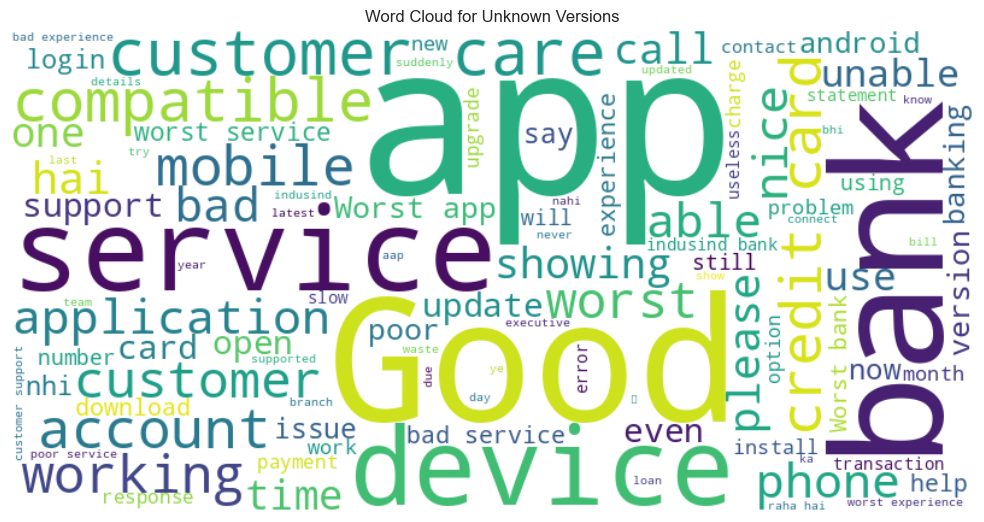


Visualizing latest versions (11+)...

Generating visualizations for: Latest Versions (11+)


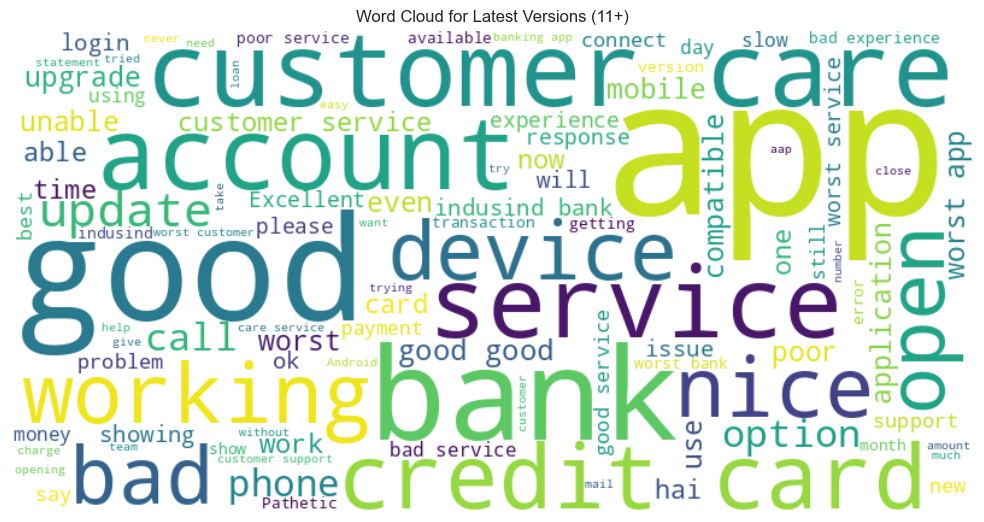

In [35]:
# Analyze version-specific visualizations for a selected version range
print("\n=== Version-Specific Visualization ===")
print("Select a version range to visualize in detail:")

# Function to create version-specific analysis
def visualize_version_range(df, title):
    print(f"\nGenerating visualizations for: {title}")
    
    # Skip if dataframe is empty
    if len(df) == 0:
        print("No data available for this version range.")
        return
    
    # Create sentiment breakdown visualization
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # 1. Sentiment pie chart
    if 'sentiment' in df.columns:
        sentiment_counts = df['sentiment'].value_counts()
        fig1 = px.pie(
            values=sentiment_counts.values,
            names=sentiment_counts.index,
            title=f"Sentiment Distribution for {title}",
            color=sentiment_counts.index,
            color_discrete_map={'positive': 'green', 'neutral': 'blue', 'negative': 'red'},
            hole=0.3
        )
        
        # Add count annotation
        fig1.add_annotation(
            text=f"Total: {len(df)} reviews",
            x=0.5, y=0.5,
            showarrow=False
        )
        
        fig1.show()
    
    # 2. Rating histogram
    if 'rating' in df.columns:
        fig2 = px.histogram(
            df, 
            x="rating", 
            color="rating",
            title=f"Rating Distribution for {title}",
            labels={"rating": "Rating", "count": "Number of Reviews"},
            category_orders={"rating": [1, 2, 3, 4, 5]},
            color_discrete_sequence=px.colors.sequential.Viridis,
            text_auto=True
        )
        
        # Update layout
        fig2.update_layout(
            xaxis=dict(
                tickmode='array',
                tickvals=[1, 2, 3, 4, 5],
                ticktext=['1 ★', '2 ★', '3 ★', '4 ★', '5 ★']
            )
        )
        
        fig2.show()
    
    # 3. Topic breakdown if available
    if 'primary_topic' in df.columns:
        topic_counts = df['primary_topic'].value_counts().head(5)
        topic_df = pd.DataFrame({
            'topic': topic_counts.index,
            'count': topic_counts.values
        })
        
        # Create a bar chart of top topics
        fig3 = px.bar(
            topic_df,
            x='topic',
            y='count',
            title=f"Top Topics for {title}",
            labels={'topic': 'Topic ID', 'count': 'Number of Reviews'},
            color='count',
            color_continuous_scale=px.colors.sequential.Blues
        )
        
        fig3.show()
    
    # 4. Word cloud or top keywords if available
    if "keywords" in analysis_results:
        # Check if we can filter keywords by this subset
        if len(df) > 100:  # Only if we have enough data
            # Get the text from this subset
            texts = df['text'].dropna().tolist()
            
            if texts:
                try:
                    from wordcloud import WordCloud
                    import matplotlib.pyplot as plt
                    
                    # Combine all texts
                    all_text = " ".join(texts)
                    
                    # Generate word cloud
                    wordcloud = WordCloud(
                        width=800, height=400,
                        background_color='white',
                        max_words=100,
                        contour_width=1
                    ).generate(all_text)
                    
                    # Display word cloud
                    plt.figure(figsize=(10, 6))
                    plt.imshow(wordcloud, interpolation='bilinear')
                    plt.axis('off')
                    plt.title(f"Word Cloud for {title}")
                    plt.tight_layout()
                    plt.show()
                except ImportError:
                    print("WordCloud library not available. Skipping word cloud visualization.")
            else:
                print("Insufficient text data for word cloud generation.")
    
    return

# Example: Visualize the current versions
print("\nVisualizing current versions (7.x)...")
visualize_version_range(current_versions_df, "Current Versions (7.x)")

# Example: Visualize unknown versions to compare
print("\nVisualizing unknown versions for comparison...")
visualize_version_range(unknown_versions_df, "Unknown Versions")

# Example: Visualize latest versions if available
if len(latest_versions_df) > 10:  # Only if we have enough data
    print("\nVisualizing latest versions (11+)...")
    visualize_version_range(latest_versions_df, "Latest Versions (11+)")

### Analyze sentiment by version

In [36]:
# Analyze sentiment by version using our new filtered datasets
print("\n=== Sentiment Analysis by Version Range ===")

# Set your preferred version range
min_version = "7.0.0"  # Min version to include
max_version = "11.0.0"  # Max version to exclude

# Create a filtered dataset for this specific range
custom_version_range_df = analyzed_df[analyzed_df['version'].apply(lambda v: version_in_range(v, min_version, max_version))].copy()
print(f"Analyzing sentiment for version range {min_version} to {max_version}: {len(custom_version_range_df)} reviews")

# Check if we have data to analyze
if len(custom_version_range_df) > 0:
    # Get sentiment breakdown
    if 'sentiment' in custom_version_range_df.columns:
        sentiment_counts = custom_version_range_df['sentiment'].value_counts()
        print("\nSentiment distribution for this version range:")
        print(sentiment_counts)
        
        # Calculate percentages
        sentiment_pct = sentiment_counts / len(custom_version_range_df) * 100
        print("\nSentiment percentages:")
        for sentiment, pct in sentiment_pct.items():
            print(f"  {sentiment}: {pct:.1f}%")
        
        # Average rating for this version range
        if 'rating' in custom_version_range_df.columns:
            avg_rating = custom_version_range_df['rating'].mean()
            print(f"\nAverage rating for this version range: {avg_rating:.2f}/5.0")
            
        # Compare with the full dataset
        full_sentiment_pct = analyzed_df['sentiment'].value_counts() / len(analyzed_df) * 100
        
        print("\nComparison with full dataset:")
        for sentiment in sentiment_counts.index:
            version_pct = sentiment_pct.get(sentiment, 0)
            full_pct = full_sentiment_pct.get(sentiment, 0)
            diff = version_pct - full_pct
            direction = "higher" if diff > 0 else "lower"
            print(f"  {sentiment}: {version_pct:.1f}% ({abs(diff):.1f}% {direction} than full dataset)")
        
        # Create a visualization of the sentiment comparison
        import plotly.express as px
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
        
        # Prepare data for pie charts
        version_sentiments = sentiment_counts.index.tolist()
        version_counts = sentiment_counts.values.tolist()
        
        full_sentiment_counts = analyzed_df['sentiment'].value_counts()
        full_sentiments = full_sentiment_counts.index.tolist()
        full_counts = full_sentiment_counts.values.tolist()

        # Create a color mapping for consistent colors
        colors = {'positive': 'green', 'neutral': 'blue', 'negative': 'red'}
        version_colors = [colors.get(s, 'gray') for s in version_sentiments]
        full_colors = [colors.get(s, 'gray') for s in full_sentiments]
        
        # Create figure with subplots
        fig = make_subplots(
            rows=1, cols=2, 
            subplot_titles=[f"Versions {min_version} to {max_version}", "All Versions"],
            specs=[[{'type': 'pie'}, {'type': 'pie'}]]
        )
        
        # Add version range pie chart
        fig.add_trace(
            go.Pie(
                labels=version_sentiments, 
                values=version_counts,
                name="Version Range",
                marker=dict(colors=version_colors),
                textinfo='percent+label'
            ),
            row=1, col=1
        )
        
        # Add full dataset pie chart
        fig.add_trace(
            go.Pie(
                labels=full_sentiments, 
                values=full_counts,
                name="All Versions",
                marker=dict(colors=full_colors),
                textinfo='percent+label'
            ),
            row=1, col=2
        )
        
        # Update layout
        fig.update_layout(
            title_text=f"Sentiment Comparison: Versions {min_version} to {max_version} vs All Reviews",
            height=500
        )
        
        # Show the figure
        fig.show()
        
        # Create a version-specific sentiment bar chart
        fig_bar = px.bar(
            x=sentiment_counts.index,
            y=sentiment_counts.values,
            color=sentiment_counts.index,
            title=f"Sentiment Distribution for Versions {min_version} to {max_version}",
            labels={"x": "Sentiment", "y": "Count", "color": "Sentiment"},
            color_discrete_map=colors,
            text=sentiment_pct.apply(lambda x: f"{x:.1f}%")
        )
        
        fig_bar.update_layout(
            xaxis_title="Sentiment",
            yaxis_title="Number of Reviews"
        )
        
        fig_bar.show()
        
        # Analyze sentiment by specific versions within this range
        # Get the top 5 versions by review count in this range
        top_versions = custom_version_range_df['version'].value_counts().head(5)
        
        print(f"\nSentiment breakdown for top 5 versions within {min_version} to {max_version}:")
        for version, count in top_versions.items():
            version_df = custom_version_range_df[custom_version_range_df['version'] == version]
            version_sentiment = version_df['sentiment'].value_counts(normalize=True) * 100
            version_rating = version_df['rating'].mean()
            
            print(f"\nVersion {version} ({count} reviews):")
            print(f"  Average rating: {version_rating:.2f}")
            for sentiment, pct in version_sentiment.items():
                print(f"  {sentiment}: {pct:.1f}%")
        
        # Create a stacked bar chart for these top versions
        sentiment_by_version = pd.crosstab(
            custom_version_range_df['version'], 
            custom_version_range_df['sentiment'],
            normalize='index'
        ) * 100
        
        # Add count column
        version_counts = custom_version_range_df['version'].value_counts()
        sentiment_by_version['review_count'] = version_counts
        
        # Filter to top versions
        top_sentiment_data = sentiment_by_version.loc[top_versions.index].reset_index()
        
        # Create figure
        fig2 = go.Figure()
        
        # Add bars for each sentiment type
        sentiments = ['positive', 'neutral', 'negative']
        
        for sentiment in sentiments:
            if sentiment in top_sentiment_data.columns:
                fig2.add_trace(go.Bar(
                    x=top_sentiment_data['version'],
                    y=top_sentiment_data[sentiment],
                    name=sentiment.capitalize(),
                    marker_color=colors.get(sentiment, 'gray'),
                    text=top_sentiment_data[sentiment].apply(lambda x: f"{x:.1f}%"),
                    textposition='auto'
                ))
        
        # Add review counts above the bars
        fig2.add_trace(go.Scatter(
            x=top_sentiment_data['version'],
            y=[100] * len(top_sentiment_data),  # Position at the top
            text=top_sentiment_data['review_count'].apply(lambda x: f"n={int(x)}"),
            mode="text",
            showlegend=False
        ))
        
        # Update layout
        fig2.update_layout(
            title=f"Sentiment Distribution by Version ({min_version} to {max_version})",
            xaxis_title="Version",
            yaxis_title="Percentage",
            barmode='stack',
            height=500
        )
        
        # Show the figure
        fig2.show()
        
    else:
        print("No sentiment data available for analysis.")
else:
    print(f"No reviews found in the version range {min_version} to {max_version}.")


=== Sentiment Analysis by Version Range ===
Analyzing sentiment for version range 7.0.0 to 11.0.0: 4216 reviews

Sentiment distribution for this version range:
sentiment
negative    2286
positive    1777
neutral      153
Name: count, dtype: int64

Sentiment percentages:
  negative: 54.2%
  positive: 42.1%
  neutral: 3.6%

Average rating for this version range: 2.73/5.0

Comparison with full dataset:
  negative: 54.2% (1.7% lower than full dataset)
  positive: 42.1% (1.4% higher than full dataset)
  neutral: 3.6% (0.3% higher than full dataset)



Sentiment breakdown for top 5 versions within 7.0.0 to 11.0.0:

Version 10.11.17 (1724 reviews):
  Average rating: 2.56
  negative: 58.7%
  positive: 38.2%
  neutral: 3.1%

Version 9.2.14.7 (1312 reviews):
  Average rating: 3.25
  positive: 54.7%
  negative: 40.6%
  neutral: 4.6%

Version 10.11.22 (473 reviews):
  Average rating: 2.43
  negative: 62.6%
  positive: 34.7%
  neutral: 2.7%

Version 10.11.18 (337 reviews):
  Average rating: 2.45
  negative: 62.0%
  positive: 35.0%
  neutral: 3.0%

Version 10.11.15 (123 reviews):
  Average rating: 2.74
  negative: 52.8%
  positive: 43.1%
  neutral: 4.1%


### Analyze Topic Distribution by Version

In [37]:
# Analyze topic distribution by version
if 'version' in analyzed_df.columns and 'primary_topic' in analyzed_df.columns:
    # Get valid versions and topics
    version_topic_df = analyzed_df.dropna(subset=['version', 'primary_topic'])
    
    valid_records = len(version_topic_df)
    if valid_records > 0:
        print(f"Found {valid_records} reviews with both version and topic data")
        
        # Get topic information if available
        if "topics" in analysis_results:
            _, topic_words = analysis_results["topics"]
            # Create a mapping of topic IDs to readable names
            topic_names = {}
            for topic_id, words in topic_words.items():
                topic_names[float(topic_id)] = f"Topic {topic_id}: {', '.join(words[:3])}"
        else:
            # Create simple topic names
            unique_topics = version_topic_df['primary_topic'].unique()
            topic_names = {topic: f"Topic {int(topic)}" for topic in unique_topics}
        
        # Calculate topic percentages per version
        topic_by_version = pd.crosstab(
            version_topic_df['version'], 
            version_topic_df['primary_topic'],
            normalize='index'
        ) * 100
        
        # Add count column
        version_counts = version_topic_df['version'].value_counts()
        topic_by_version['review_count'] = version_counts
        
        # Sort by review count
        topic_by_version = topic_by_version.reset_index()
        topic_by_version = topic_by_version.sort_values('review_count', ascending=False)
        
        # Round percentages for display
        display_cols = topic_by_version.columns.difference(['version', 'review_count'])
        topic_by_version[display_cols] = topic_by_version[display_cols].round(1)
        
        # Rename topic columns with readable names (limited to top topics)
        if len(display_cols) <= 10:  # Only rename if we have a reasonable number of topics
            renamed_cols = {}
            for col in display_cols:
                if col in topic_names:
                    renamed_cols[col] = topic_names[col]
            
            if renamed_cols:
                topic_by_version = topic_by_version.rename(columns=renamed_cols)
        
        # Display results for top versions
        print("\nTopic distribution by version (percentage):")
        display(topic_by_version.head(10))
        
        # Find most distinctive topics for each version
        print("\nMost distinctive topics by version:")
        top_versions = topic_by_version.head(10)['version'].tolist()
        
        for version in top_versions:
            version_row = topic_by_version[topic_by_version['version'] == version].iloc[0]
            topic_cols = version_row.index.difference(['version', 'review_count'])
            
            # Convert to numeric type for sorting (fix for the TypeError)
            topic_values = pd.Series(version_row[topic_cols].values, index=topic_cols).astype(float)
            # Get top 3 topics by value
            top_topics = topic_values.nlargest(3)
            
            print(f"\nVersion {version} (reviews: {version_row['review_count']}):")
            for topic_col, percentage in top_topics.items():
                # Get original topic ID if column names were renamed
                if topic_col in topic_names.values():
                    topic_id = next(k for k, v in topic_names.items() if v == topic_col)
                else:
                    try:
                        topic_id = float(topic_col)
                    except:
                        topic_id = topic_col
                
                # Get associated words if available
                if "topics" in analysis_results and str(int(topic_id)) in topic_words:
                    words = topic_words[str(int(topic_id))][:5]
                    print(f"  {topic_col}: {percentage:.1f}% (keywords: {', '.join(words)})")
                else:
                    print(f"  {topic_col}: {percentage:.1f}%")
        
    else:
        print("No reviews with both version and topic data found")
else:
    missing_cols = []
    if 'version' not in analyzed_df.columns:
        missing_cols.append('version')
    if 'primary_topic' not in analyzed_df.columns:
        missing_cols.append('primary_topic')
    
    print(f"Cannot perform version topic analysis: missing {', '.join(missing_cols)} data")

Found 4875 reviews with both version and topic data

Topic distribution by version (percentage):


primary_topic,version,"Topic 0: like, charge, use","Topic 1: bad, service, experience","Topic 2: app, working, device","Topic 3: service, customer, poor","Topic 4: worst, bank, app","Topic 5: card, credit, payment","Topic 6: good, update, app","Topic 7: nice, able, version","Topic 8: customer, care, service","Topic 9: account, bank, hai",review_count
1,10.11.17,4.3,8.4,10.5,15.6,9.7,7.7,23.1,8.3,7.4,4.9,1683
39,9.2.14.7,3.6,6.8,27.3,5.4,5.5,2.5,34.1,9.4,3.1,2.4,1259
44,Unknown,5.3,7.1,23.9,13.3,9.2,4.5,20.2,7.2,4.7,4.5,773
5,10.11.22,4.3,9.3,16.0,13.2,9.3,8.0,20.7,8.0,6.9,4.3,463
2,10.11.18,3.6,10.9,10.6,14.6,10.9,5.8,21.9,8.5,7.3,5.8,329
0,10.11.15,4.1,9.8,22.1,9.8,9.0,7.4,23.8,7.4,4.1,2.5,122
3,10.11.20,3.6,18.2,9.1,16.4,10.9,5.5,18.2,9.1,3.6,5.5,55
37,9.2.14.2,7.4,3.7,33.3,3.7,14.8,3.7,22.2,3.7,0.0,7.4,27
25,9.2.12.5,6.2,0.0,43.8,18.8,6.2,6.2,6.2,6.2,0.0,6.2,16
22,9.2.10.2,0.0,7.1,50.0,0.0,0.0,7.1,14.3,7.1,7.1,7.1,14



Most distinctive topics by version:

Version 10.11.17 (reviews: 1683):
  Topic 6: good, update, app: 23.1%
  Topic 3: service, customer, poor: 15.6%
  Topic 2: app, working, device: 10.5%

Version 9.2.14.7 (reviews: 1259):
  Topic 6: good, update, app: 34.1%
  Topic 2: app, working, device: 27.3%
  Topic 7: nice, able, version: 9.4%

Version Unknown (reviews: 773):
  Topic 2: app, working, device: 23.9%
  Topic 6: good, update, app: 20.2%
  Topic 3: service, customer, poor: 13.3%

Version 10.11.22 (reviews: 463):
  Topic 6: good, update, app: 20.7%
  Topic 2: app, working, device: 16.0%
  Topic 3: service, customer, poor: 13.2%

Version 10.11.18 (reviews: 329):
  Topic 6: good, update, app: 21.9%
  Topic 3: service, customer, poor: 14.6%
  Topic 1: bad, service, experience: 10.9%

Version 10.11.15 (reviews: 122):
  Topic 6: good, update, app: 23.8%
  Topic 2: app, working, device: 22.1%
  Topic 1: bad, service, experience: 9.8%

Version 10.11.20 (reviews: 55):
  Topic 1: bad, service,

### Developer Response Analysis

The `repliedAt` column contains valuable information about when developers responded to reviews. This analysis examines response patterns and their impact on ratings.

In [38]:
# Analyze developer responses for our selected version range
print("\n=== Developer Response Analysis for Selected Version Range ===")

# Use the same version range as defined in the sentiment analysis
print(f"Analyzing developer responses for version range {min_version} to {max_version}")

# Check if we have response data
if 'repliedAt' in custom_version_range_df.columns:
    # Check response rate for this version range
    has_response = custom_version_range_df['repliedAt'].notna()
    response_count = has_response.sum()
    response_rate = response_count / len(custom_version_range_df) * 100
    
    print(f"\nDeveloper response rate for versions {min_version} to {max_version}: {response_count}/{len(custom_version_range_df)} ({response_rate:.2f}%)")
    
    # Create binary response column for analysis
    custom_version_range_df['has_response'] = has_response
    
    # Compare with overall response rate
    overall_response_count = analyzed_df['repliedAt'].notna().sum()
    overall_response_rate = overall_response_count / len(analyzed_df) * 100
    
    print(f"Overall developer response rate (all versions): {overall_response_count}/{len(analyzed_df)} ({overall_response_rate:.2f}%)")
    
    # Calculate difference
    diff = response_rate - overall_response_rate
    direction = "higher" if diff > 0 else "lower"
    print(f"Response rate is {abs(diff):.2f}% {direction} for this version range compared to all versions")
    
    # Compare ratings for responded vs non-responded reviews in this version range
    if 'rating' in custom_version_range_df.columns:
        rating_by_response = custom_version_range_df.groupby('has_response')['rating'].agg(['mean', 'count']).reset_index()
        rating_by_response.columns = ['has_response', 'avg_rating', 'count']
        rating_by_response['avg_rating'] = rating_by_response['avg_rating'].round(2)
        rating_by_response['has_response'] = rating_by_response['has_response'].map({True: 'Responded', False: 'Not Responded'})
        
        print("\nAverage rating by developer response (versions {min_version} to {max_version}):")
        display(rating_by_response)
    
    # Analyze responses by specific version within the range
    # Get the top 5 versions by review count within this range
    top_versions = custom_version_range_df['version'].value_counts().head(5)
    
    # Calculate response rate by version
    response_by_version = custom_version_range_df.groupby('version')['has_response'].agg(['mean', 'sum', 'count']).reset_index()
    response_by_version.columns = ['version', 'response_rate', 'responded', 'total']
    response_by_version['response_rate'] = (response_by_version['response_rate'] * 100).round(1)
    
    # Filter to top versions and sort by response rate
    top_version_response = response_by_version[response_by_version['version'].isin(top_versions.index)]
    top_version_response = top_version_response.sort_values('response_rate', ascending=False)
    
    print(f"\nResponse rate by top versions within {min_version} to {max_version}:")
    display(top_version_response)
    
    # Check for responses to negative reviews in this version range
    if 'rating' in custom_version_range_df.columns:
        # Define negative ratings (1-2 stars)
        negative_reviews = custom_version_range_df[custom_version_range_df['rating'] <= 2]
        negative_count = len(negative_reviews)
        
        if negative_count > 0:
            negative_response_count = negative_reviews['has_response'].sum()
            negative_response_rate = negative_response_count / negative_count * 100
            
            print(f"\nResponse rate to negative reviews (1-2 stars) in this version range: {negative_response_count}/{negative_count} ({negative_response_rate:.2f}%)")
            
            # Compare to positive reviews
            positive_reviews = custom_version_range_df[custom_version_range_df['rating'] >= 4]
            positive_count = len(positive_reviews)
            
            if positive_count > 0:
                positive_response_count = positive_reviews['has_response'].sum()
                positive_response_rate = positive_response_count / positive_count * 100
                
                print(f"Response rate to positive reviews (4-5 stars) in this version range: {positive_response_count}/{positive_count} ({positive_response_rate:.2f}%)")
                
                # Calculate ratio of response rates
                if positive_response_rate > 0:
                    ratio = negative_response_rate / positive_response_rate
                    print(f"Negative reviews are {ratio:.1f}x more likely to receive a response than positive reviews")
    
    # Create visualizations for response analysis
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # 1. Response rate by version bar chart
    if len(top_version_response) > 0:
        fig = px.bar(
            top_version_response,
            x='version',
            y='response_rate',
            title=f"Developer Response Rate by Version ({min_version} to {max_version})",
            labels={'version': 'App Version', 'response_rate': 'Response Rate (%)'},
            text=top_version_response['response_rate'].apply(lambda x: f"{x:.1f}%"),
            color='response_rate',
            color_continuous_scale='Blues'
        )
        
        # Add review counts
        fig.add_trace(
            go.Scatter(
                x=top_version_response['version'],
                y=[0] * len(top_version_response),  # Position at the bottom
                text=top_version_response['total'].apply(lambda x: f"n={int(x)}"),
                mode="text",
                showlegend=False
            )
        )
        
        # Update layout
        fig.update_layout(
            height=500,
            yaxis=dict(range=[-5, max(top_version_response['response_rate']) * 1.1])
        )
        
        # Show figure
        fig.show()
    
    # 2. Response rate by rating
    if 'rating' in custom_version_range_df.columns:
        response_by_rating = custom_version_range_df.groupby('rating')['has_response'].agg(['mean', 'sum', 'count']).reset_index()
        response_by_rating.columns = ['rating', 'response_rate', 'responded', 'total']
        response_by_rating['response_rate'] = (response_by_rating['response_rate'] * 100).round(1)
        
        # Create bar chart
        fig2 = px.bar(
            response_by_rating,
            x='rating',
            y='response_rate',
            title=f"Developer Response Rate by Rating ({min_version} to {max_version})",
            labels={'rating': 'Rating', 'response_rate': 'Response Rate (%)'},
            text=response_by_rating['response_rate'].apply(lambda x: f"{x:.1f}%"),
            color='response_rate',
            color_continuous_scale='Blues'
        )
        
        # Add review counts
        fig2.add_trace(
            go.Scatter(
                x=response_by_rating['rating'],
                y=[0] * len(response_by_rating),  # Position at the bottom
                text=response_by_rating['total'].apply(lambda x: f"n={int(x)}"),
                mode="text",
                showlegend=False
            )
        )
        
        # Update layout
        fig2.update_layout(
            height=500,
            yaxis=dict(range=[-5, max(response_by_rating['response_rate']) * 1.1]),
            xaxis=dict(
                tickmode='array',
                tickvals=[1, 2, 3, 4, 5],
                ticktext=['1 ★', '2 ★', '3 ★', '4 ★', '5 ★']
            )
        )
        
        # Show figure
        fig2.show()
    
    # 3. Pie chart comparison of response vs non-response
    response_distribution = custom_version_range_df['has_response'].value_counts()
    response_labels = ['Responded', 'Not Responded']
    response_values = [response_distribution.get(True, 0), response_distribution.get(False, 0)]
    
    fig3 = px.pie(
        values=response_values,
        names=response_labels,
        title=f"Developer Response Distribution ({min_version} to {max_version})",
        color=response_labels,
        color_discrete_map={'Responded': 'darkblue', 'Not Responded': 'lightgray'},
        hole=0.4
    )
    
    # Add annotation in the center
    fig3.add_annotation(
        text=f"{response_rate:.1f}%<br>Response Rate",
        x=0.5, y=0.5,
        font_size=14,
        showarrow=False
    )
    
    # Show figure
    fig3.show()
    
    # Examine replyContent sample if available (only from this version range)
    if 'replyContent' in custom_version_range_df.columns:
        replied_reviews = custom_version_range_df[custom_version_range_df['replyContent'].notna()]
        reply_sample_count = min(3, len(replied_reviews))
        
        if reply_sample_count > 0:
            print(f"\nSample developer replies for versions {min_version} to {max_version}:")
            
            # Sample from different ratings if possible
            sampled_replies = []
            for rating in sorted(replied_reviews['rating'].unique()):
                rating_replies = replied_reviews[replied_reviews['rating'] == rating]
                if len(rating_replies) > 0:
                    # Take one sample from each rating
                    sampled_replies.append(rating_replies.sample(1))
            
            # Combine samples (up to 3)
            sample_df = pd.concat(sampled_replies)[:3]
            
            # Show rating, review text, and reply
            for _, row in sample_df.iterrows():
                version = row.get('version', 'N/A')
                print(f"\nVersion: {version}, Rating: {row.get('rating', 'N/A')}")
                print(f"Review: {row.get('text', 'N/A')[:100]}..." if len(row.get('text', '')) > 100 else f"Review: {row.get('text', 'N/A')}")
                print(f"Reply: {row.get('replyContent', 'N/A')[:100]}..." if len(row.get('replyContent', '')) > 100 else f"Reply: {row.get('replyContent', 'N/A')}")
else:
    print("No developer response data (repliedAt column) found in the dataset.")


=== Developer Response Analysis for Selected Version Range ===
Analyzing developer responses for version range 7.0.0 to 11.0.0

Developer response rate for versions 7.0.0 to 11.0.0: 1648/4216 (39.09%)
Overall developer response rate (all versions): 1945/5000 (38.90%)
Response rate is 0.19% higher for this version range compared to all versions

Average rating by developer response (versions {min_version} to {max_version}):


,has_response,avg_rating,count
0,Not Responded,2.70,2568
1,Responded,2.79,1648



Response rate by top versions within 7.0.0 to 11.0.0:


,version,response_rate,responded,total
0,10.11.15,78.0,96,123
38,9.2.14.7,59.8,784,1312
1,10.11.17,32.8,566,1724
2,10.11.18,14.5,49,337
5,10.11.22,4.0,19,473



Response rate to negative reviews (1-2 stars) in this version range: 866/2286 (37.88%)
Response rate to positive reviews (4-5 stars) in this version range: 710/1777 (39.95%)
Negative reviews are 0.9x more likely to receive a response than positive reviews



Sample developer replies for versions 7.0.0 to 11.0.0:

Version: 10.11.17, Rating: 1
Review: after kyc bank show your account freeze very bad service alwar bhagat singh brench employees not wor...
Reply: Dear Customer, We request you to write to us on socialm@indusind.com, along with your contact number...

Version: 10.11.18, Rating: 2
Review: not good
Reply: Dear Customer, We request you to write to us on socialm@indusind.com, along with your contact number...

Version: 9.2.14.7, Rating: 3
Review: Nice
Reply: Dear Customer, We appreciate the feedback. Please let us know how we can earn your 5 star rating. Re...


### Version Evolution Analysis

By analyzing how ratings and sentiment have changed across major version updates, we can understand the app's improvement trajectory and identify which releases had the most positive or negative impact.

In [39]:
# Enhanced Version Evolution Analysis for our filtered version range
print("\n=== Version Evolution Analysis for Selected Range ===")
print(f"Analyzing version evolution for range {min_version} to {max_version}")

# Make sure we're working with the filtered dataset
version_analysis_df = custom_version_range_df.copy()

# Check if we have version data in our filtered dataset
if 'version' in version_analysis_df.columns and len(version_analysis_df) > 0:
    print(f"Found {len(version_analysis_df)} reviews in the selected version range")
    
    # Verify major version field exists
    if 'major_version' not in version_analysis_df.columns:
        # Extract major version number from version string
        def extract_major_version(version_str):
            if pd.isna(version_str) or version_str == "Unknown":
                return None
            try:
                # Extract first part of version (e.g., "6" from "6.0.3")
                major = version_str.split('.')[0]
                return int(major)
            except (ValueError, IndexError, AttributeError):
                return None
        
        # Create major version column
        version_analysis_df['major_version'] = version_analysis_df['version'].apply(extract_major_version)
    
    # Extract minor version components
    if 'minor_version' not in version_analysis_df.columns:
        def extract_minor_version(version_str):
            if pd.isna(version_str) or version_str == "Unknown":
                return None
            try:
                parts = str(version_str).split('.')
                minor = int(parts[1]) if len(parts) > 1 else None
                return minor
            except (ValueError, IndexError):
                return None
        
        version_analysis_df['minor_version'] = version_analysis_df['version'].apply(extract_minor_version)
    
    # Extract patch version components
    if 'patch_version' not in version_analysis_df.columns:
        def extract_patch_version(version_str):
            if pd.isna(version_str) or version_str == "Unknown":
                return None
            try:
                parts = str(version_str).split('.')
                patch = int(parts[2]) if len(parts) > 2 else None
                return patch
            except (ValueError, IndexError):
                return None
        
        version_analysis_df['patch_version'] = version_analysis_df['version'].apply(extract_patch_version)
    
    # Count reviews by complete version within our range
    version_counts = version_analysis_df['version'].value_counts()
    print(f"\nFound {len(version_counts)} unique versions in the selected range")
    print("Top 10 versions by review count:")
    display(version_counts.head(10).reset_index().rename(columns={'index': 'version', 'version': 'count'}))
    
    # Create interactive visualization of version distribution
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Top versions for visualization (showing too many makes the chart unreadable)
    top_n = min(15, len(version_counts))
    top_versions = version_counts.head(top_n)
    
    # Create bar chart
    fig = px.bar(
        x=top_versions.index,
        y=top_versions.values,
        labels={'x': 'App Version', 'y': 'Number of Reviews'},
        title=f"Review Distribution by Version ({min_version} to {max_version})",
        color=top_versions.values,
        color_continuous_scale='Viridis'
    )
    
    # Update layout
    fig.update_layout(
        xaxis_title="App Version",
        yaxis_title="Number of Reviews",
        coloraxis_colorbar=dict(title="Review Count"),
        height=500
    )
    
    # Show figure
    fig.show()
    
    # Calculate average rating by version within our filtered range
    if 'rating' in version_analysis_df.columns:
        rating_by_version = version_analysis_df.groupby('version')['rating'].agg(['mean', 'count']).reset_index()
        rating_by_version.columns = ['version', 'avg_rating', 'review_count']
        
        # Round for display
        rating_by_version['avg_rating'] = rating_by_version['avg_rating'].round(2)
        
        # Sort by review count and get top versions
        top_rated_versions = rating_by_version.sort_values('review_count', ascending=False).head(15)
        
        # Create a combined visualization showing both average rating and count
        fig2 = make_subplots(specs=[[{"secondary_y": True}]])
        
        # Add average rating bars
        fig2.add_trace(
            go.Bar(
                x=top_rated_versions['version'],
                y=top_rated_versions['avg_rating'],
                name="Average Rating",
                marker_color='rgba(55, 83, 109, 0.7)',
                text=top_rated_versions['avg_rating'],
                textposition='auto'
            ),
            secondary_y=False
        )
        
        # Add review count points with a line
        fig2.add_trace(
            go.Scatter(
                x=top_rated_versions['version'],
                y=top_rated_versions['review_count'],
                name="Review Count",
                mode='markers+lines',
                marker=dict(size=10, color='red'),
                line=dict(width=1, dash='dot')
            ),
            secondary_y=True
        )
        
        # Add reference line for neutral rating
        fig2.add_hline(y=3, line_dash="dash", line_color="grey", annotation_text="Neutral (3.0)")
        
        # Update layout
        fig2.update_layout(
            title=f"Average Rating and Review Count by Version ({min_version} to {max_version})",
            xaxis_title="App Version",
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            ),
            height=500
        )
        
        # Set y-axes titles
        fig2.update_yaxes(title_text="Average Rating", secondary_y=False, range=[1, 5])
        fig2.update_yaxes(title_text="Number of Reviews", secondary_y=True)
        
        # Show figure
        fig2.show()
        
        # Analyze ratings by minor version within major version
        # Get counts of major versions
        major_version_counts = version_analysis_df.groupby('major_version').size()
        
        # Find major versions with enough data
        significant_majors = major_version_counts[major_version_counts >= 10].index.tolist()
        
        # For each significant major version, analyze its minor versions
        for major in significant_majors:
            # Get data for this major version
            major_data = version_analysis_df[version_analysis_df['major_version'] == major]
            
            # Group by minor version
            minor_ratings = major_data.groupby('minor_version')['rating'].agg(['mean', 'count']).reset_index()
            minor_ratings.columns = ['minor_version', 'avg_rating', 'review_count']
            minor_ratings['avg_rating'] = minor_ratings['avg_rating'].round(2)
            
            # Filter to minor versions with enough data
            valid_minors = minor_ratings[minor_ratings['review_count'] >= 10]
            
            if len(valid_minors) >= 2:  # Need at least 2 minor versions to show a trend
                print(f"\nRating trends for major version {major}:")
                display(valid_minors.sort_values('minor_version'))
                
                # Create a visualization of minor version trends
                fig3 = px.line(
                    valid_minors.sort_values('minor_version'),
                    x='minor_version',
                    y='avg_rating',
                    markers=True,
                    labels={'minor_version': 'Minor Version', 'avg_rating': 'Average Rating'},
                    title=f"Rating Trends within Major Version {major}",
                    text='avg_rating'
                )
                
                # Update traces
                fig3.update_traces(
                    mode='markers+lines+text',
                    textposition='top center',
                    marker=dict(
                        size=valid_minors['review_count'] / valid_minors['review_count'].max() * 50,
                        sizemode='area',
                        sizeref=2. * max(valid_minors['review_count']) / (40.**2),
                        sizemin=5
                    )
                )
                
                # Add reference line for neutral rating
                fig3.add_hline(y=3, line_dash="dash", line_color="grey", annotation_text="Neutral (3.0)")
                
                # Update layout
                fig3.update_layout(
                    xaxis_title=f"Minor Version (Major Version {major})",
                    yaxis_title="Average Rating",
                    yaxis=dict(range=[1, 5]),
                    height=500
                )
                
                # Add review count annotations
                for i, row in valid_minors.iterrows():
                    fig3.add_annotation(
                        x=row['minor_version'],
                        y=row['avg_rating'] - 0.3,
                        text=f"n={row['review_count']}",
                        showarrow=False
                    )
                
                # Show figure
                fig3.show()
                
                # Calculate significant changes between minor versions
                valid_minors_sorted = valid_minors.sort_values('minor_version')
                valid_minors_sorted['rating_change'] = valid_minors_sorted['avg_rating'].diff()
                
                # Find significant changes
                significant_changes = valid_minors_sorted[valid_minors_sorted['rating_change'].abs() >= 0.3]
                
                if len(significant_changes) > 0:
                    print(f"\nSignificant rating changes within major version {major}:")
                    for i, row in significant_changes.iterrows():
                        prev_minor = valid_minors_sorted.iloc[i-1]['minor_version'] if i > 0 else "previous"
                        direction = "increased" if row['rating_change'] > 0 else "decreased"
                        print(f"  Version {major}.{row['minor_version']}: Rating {direction} by {abs(row['rating_change']):.2f} points from {major}.{prev_minor}")
                        
                        # Look for significant sentiment changes for this version shift
                        if 'sentiment' in major_data.columns:
                            current_minor = row['minor_version']
                            # Get sentiment distribution for current and previous minor versions
                            current_sentiment = major_data[major_data['minor_version'] == current_minor]['sentiment'].value_counts(normalize=True) * 100
                            prev_sentiment = major_data[major_data['minor_version'] == prev_minor]['sentiment'].value_counts(normalize=True) * 100
                            
                            # Check differences in sentiment
                            for sentiment in ['positive', 'negative']:
                                if sentiment in current_sentiment and sentiment in prev_sentiment:
                                    diff = current_sentiment[sentiment] - prev_sentiment[sentiment]
                                    if abs(diff) >= 5:  # Only report significant changes (5% or more)
                                        sent_direction = "increased" if diff > 0 else "decreased"
                                        print(f"    {sentiment.capitalize()} sentiment {sent_direction} by {abs(diff):.1f}% points")
        
        # Identify overall version trends
        # Analyze across major versions
        major_ratings = version_analysis_df.groupby('major_version')['rating'].agg(['mean', 'count']).reset_index()
        major_ratings.columns = ['major_version', 'avg_rating', 'review_count']
        major_ratings['avg_rating'] = major_ratings['avg_rating'].round(2)
        
        # Filter to versions with sufficient data
        major_ratings = major_ratings[major_ratings['review_count'] >= 10]
        
        if len(major_ratings) >= 2:  # Need at least 2 points for a trend
            # Sort by major version
            major_ratings = major_ratings.sort_values('major_version')
            
            print("\nOverall rating trends by major version:")
            display(major_ratings)
            
            # Create visualization
            fig4 = px.line(
                major_ratings,
                x='major_version',
                y='avg_rating',
                markers=True,
                labels={'major_version': 'Major Version', 'avg_rating': 'Average Rating'},
                title="Rating Trends by Major Version",
                text='avg_rating'
            )
            
            # Update traces
            fig4.update_traces(
                mode='markers+lines+text',
                textposition='top center',
                marker=dict(
                    size=major_ratings['review_count'] / major_ratings['review_count'].max() * 50,
                    sizemode='area',
                    sizeref=2. * max(major_ratings['review_count']) / (40.**2),
                    sizemin=5
                )
            )
            
            # Add reference line for neutral rating
            fig4.add_hline(y=3, line_dash="dash", line_color="grey")
            
            # Update layout
            fig4.update_layout(
                xaxis_title="Major Version",
                yaxis_title="Average Rating",
                yaxis=dict(range=[1, 5]),
                height=500
            )
            
            # Add review count annotations
            for i, row in major_ratings.iterrows():
                fig4.add_annotation(
                    x=row['major_version'],
                    y=row['avg_rating'] - 0.3,
                    text=f"n={row['review_count']}",
                    showarrow=False
                )
            
            # Show figure
            fig4.show()
            
            # Calculate overall trend
            first_rating = major_ratings.iloc[0]['avg_rating']
            last_rating = major_ratings.iloc[-1]['avg_rating']
            overall_change = last_rating - first_rating
            
            if abs(overall_change) >= 0.1:
                direction = "increased" if overall_change > 0 else "decreased"
                print(f"\nOverall trend: Ratings have {direction} by {abs(overall_change):.2f} points from version {major_ratings.iloc[0]['major_version']} to {major_ratings.iloc[-1]['major_version']}")
    
    # Add key findings summary
    print("\n=== KEY INSIGHTS FROM VERSION ANALYSIS ===")
    
    # 1. Most reviewed versions
    top_version = version_counts.idxmax()
    print(f"1. Most reviewed version: {top_version} with {version_counts.max()} reviews")
    
    # 2. Highest rated versions
    if 'rating' in version_analysis_df.columns:
        # Filter to versions with enough reviews for statistical significance
        min_reviews = 10
        significant_versions = rating_by_version[rating_by_version['review_count'] >= min_reviews]
        
        if len(significant_versions) > 0:
            best_version = significant_versions.sort_values('avg_rating', ascending=False).iloc[0]
            print(f"2. Highest rated version: {best_version['version']} with average rating {best_version['avg_rating']}/5.0 ({int(best_version['review_count'])} reviews)")
            
            worst_version = significant_versions.sort_values('avg_rating').iloc[0]
            print(f"3. Lowest rated version: {worst_version['version']} with average rating {worst_version['avg_rating']}/5.0 ({int(worst_version['review_count'])} reviews)")
    
    # 3. Version distribution insights
    major_dist = version_analysis_df['major_version'].value_counts()
    
    if len(major_dist) > 0:
        dominant_major = major_dist.idxmax()
        print(f"4. Dominant major version: {dominant_major}.x accounts for {major_dist.max()/len(version_analysis_df)*100:.1f}% of reviews in this range")
    
    # 4. Check for sentiment distribution by version
    if 'sentiment' in version_analysis_df.columns:
        version_sentiment = pd.crosstab(
            version_analysis_df['version'], 
            version_analysis_df['sentiment'],
            normalize='index'
        ) * 100
        
        # Add count column
        version_sentiment['review_count'] = version_analysis_df['version'].value_counts()
        
        # Filter to versions with sufficient reviews
        significant_sentiment = version_sentiment[version_sentiment['review_count'] >= min_reviews].reset_index()
        
        if len(significant_sentiment) > 0 and 'positive' in significant_sentiment.columns:
            # Find most positive version
            most_positive = significant_sentiment.sort_values('positive', ascending=False).iloc[0]
            print(f"5. Most positive sentiment: Version {most_positive['version']} with {most_positive['positive']:.1f}% positive reviews")
            
            # Find most negative version if column exists
            if 'negative' in significant_sentiment.columns:
                most_negative = significant_sentiment.sort_values('negative', ascending=False).iloc[0]
                print(f"6. Most negative sentiment: Version {most_negative['version']} with {most_negative['negative']:.1f}% negative reviews")
    
else:
    print("Insufficient version data for analysis in the specified range.")


=== Version Evolution Analysis for Selected Range ===
Analyzing version evolution for range 7.0.0 to 11.0.0
Found 4216 reviews in the selected version range

Found 43 unique versions in the selected range
Top 10 versions by review count:


,count,count
0,10.11.17,1724
1,9.2.14.7,1312
2,10.11.22,473
3,10.11.18,337
4,10.11.15,123
5,10.11.20,56
6,9.2.14.2,28
7,9.2.12.5,16
8,9.2.10.2,14
9,9.2.12.6,13



Overall rating trends by major version:


,major_version,avg_rating,review_count
1,8.0,2.43,14
2,9.0,3.11,1481
3,10.0,2.53,2720



=== KEY INSIGHTS FROM VERSION ANALYSIS ===
1. Most reviewed version: 10.11.17 with 1724 reviews
2. Highest rated version: 9.2.14.7 with average rating 3.25/5.0 (1312 reviews)
3. Lowest rated version: 9.2.12.6 with average rating 1.62/5.0 (13 reviews)
4. Dominant major version: 10.0.x accounts for 64.5% of reviews in this range
5. Most positive sentiment: Version 9.2.14.7 with 54.7% positive reviews
6. Most negative sentiment: Version 9.2.12.6 with 84.6% negative reviews


### Key Findings from Version-Based Analysis

This section summarizes the key findings from our version-based analysis, highlighting the impact of different versions on user sentiment, critical issues, and areas for improvement. These insights can help prioritize development efforts for future versions.

In [40]:
# Summarize key findings from version analysis
print("Extracting key findings from version-based analysis:")

# Check for minimally required data
has_version = 'version' in analyzed_df.columns
has_rating = 'rating' in analyzed_df.columns
has_topics = 'primary_topic' in analyzed_df.columns
has_sentiment = 'sentiment' in analyzed_df.columns
has_response = 'repliedAt' in analyzed_df.columns

if not has_version:
    print("No version data available for findings summary.")
else:
    # Calculate the percentage of reviews with version data
    version_count = analyzed_df['version'].notna().sum()
    version_pct = version_count / len(analyzed_df) * 100
    print(f"Found version data in {version_count}/{len(analyzed_df)} reviews ({version_pct:.1f}%)")
    
    findings = []
    
    # 1. Check for any particularly bad versions
    if has_rating:
        # Find versions with sufficient reviews for analysis
        min_reviews = 10
        version_ratings = analyzed_df.groupby('version')['rating'].agg(['mean', 'count']).reset_index()
        version_ratings.columns = ['version', 'avg_rating', 'review_count']
        
        # Filter to versions with enough reviews
        valid_versions = version_ratings[version_ratings['review_count'] >= min_reviews]
        
        if len(valid_versions) > 0:
            # Find worst versions
            worst_versions = valid_versions.sort_values('avg_rating').head(3)
            
            for _, row in worst_versions.iterrows():
                if row['avg_rating'] < 3.0:  # Only include if below neutral
                    findings.append(f"Version {row['version']} has a low average rating of {row['avg_rating']:.1f}/5 based on {int(row['review_count'])} reviews.")
            
            # Find best versions
            best_versions = valid_versions.sort_values('avg_rating', ascending=False).head(3)
            
            for _, row in best_versions.iterrows():
                if row['avg_rating'] > 3.5:  # Only include if notably above neutral
                    findings.append(f"Version {row['version']} has a high average rating of {row['avg_rating']:.1f}/5 based on {int(row['review_count'])} reviews.")
    
    # 2. Check for major version trends
    if has_rating and 'major_version' in analyzed_df.columns:
        # Look for trends across major versions
        major_ratings = analyzed_df.groupby('major_version')['rating'].agg(['mean', 'count']).reset_index()
        major_ratings.columns = ['major_version', 'avg_rating', 'review_count']
        
        # Filter to major versions with enough reviews and sort
        valid_majors = major_ratings[major_ratings['review_count'] >= min_reviews].sort_values('major_version')
        
        if len(valid_majors) >= 3:  # Need at least 3 points for a trend
            # Calculate rating changes between versions
            valid_majors['rating_change'] = valid_majors['avg_rating'].diff()
            
            # Check if there's a notable trend
            first_rating = valid_majors.iloc[0]['avg_rating']
            last_rating = valid_majors.iloc[-1]['avg_rating']
            overall_change = last_rating - first_rating
            
            # Add findings on overall trend
            if abs(overall_change) >= 0.5:  # Only report significant changes
                if overall_change > 0:
                    findings.append(f"Ratings show improvement across major versions, from {first_rating:.1f} (version {valid_majors.iloc[0]['major_version']}) to {last_rating:.1f} (version {valid_majors.iloc[-1]['major_version']}).")
                else:
                    findings.append(f"Ratings show decline across major versions, from {first_rating:.1f} (version {valid_majors.iloc[0]['major_version']}) to {last_rating:.1f} (version {valid_majors.iloc[-1]['major_version']}).")
            
            # Find biggest improvements
            biggest_improvement = valid_majors[valid_majors['rating_change'] > 0].sort_values('rating_change', ascending=False).head(1)
            if len(biggest_improvement) > 0 and biggest_improvement.iloc[0]['rating_change'] >= 0.5:
                row = biggest_improvement.iloc[0]
                # Safely find previous version by looking for the row's position
                # Find the current row's index position
                try:
                    current_idx = valid_majors.index[valid_majors['major_version'] == row['major_version']].tolist()[0]
                    if current_idx > 0:  # Make sure there's a previous row
                        prev_version = valid_majors.iloc[current_idx-1]['major_version']
                        findings.append(f"Biggest improvement was from version {prev_version} to {row['major_version']}, with ratings increasing by {row['rating_change']:.1f} points.")
                except (IndexError, KeyError):
                    pass  # Skip if we can't find the previous version
            
            # Find biggest declines
            biggest_decline = valid_majors[valid_majors['rating_change'] < 0].sort_values('rating_change').head(1)
            if len(biggest_decline) > 0 and biggest_decline.iloc[0]['rating_change'] <= -0.5:
                row = biggest_decline.iloc[0]
                # Safely find previous version by looking for the row's position
                try:
                    current_idx = valid_majors.index[valid_majors['major_version'] == row['major_version']].tolist()[0]
                    if current_idx > 0:  # Make sure there's a previous row
                        prev_version = valid_majors.iloc[current_idx-1]['major_version']
                        findings.append(f"Biggest decline was from version {prev_version} to {row['major_version']}, with ratings dropping by {abs(row['rating_change']):.1f} points.")
                except (IndexError, KeyError):
                    pass  # Skip if we can't find the previous version
    
    # 3. Check for sentiment changes across versions
    if has_sentiment and has_version:
        version_sentiment = pd.crosstab(
            analyzed_df['version'], 
            analyzed_df['sentiment'],
            normalize='index'
        ) * 100
        
        # Add count column
        version_counts = analyzed_df.groupby('version').size()
        version_sentiment['review_count'] = version_counts
        
        # Filter to versions with enough reviews
        valid_sentiment = version_sentiment[version_sentiment['review_count'] >= min_reviews].reset_index()
        
        if len(valid_sentiment) > 0 and 'positive' in valid_sentiment.columns:
            # Find versions with highest positive sentiment
            top_positive = valid_sentiment.sort_values('positive', ascending=False).head(1)
            if len(top_positive) > 0 and top_positive.iloc[0]['positive'] >= 60:
                row = top_positive.iloc[0]
                findings.append(f"Version {row['version']} has the highest positive sentiment at {row['positive']:.1f}% based on {int(row['review_count'])} reviews.")
            
            # Find versions with highest negative sentiment
            if 'negative' in valid_sentiment.columns:
                top_negative = valid_sentiment.sort_values('negative', ascending=False).head(1)
                if len(top_negative) > 0 and top_negative.iloc[0]['negative'] >= 60:
                    row = top_negative.iloc[0]
                    findings.append(f"Version {row['version']} has the highest negative sentiment at {row['negative']:.1f}% based on {int(row['review_count'])} reviews.")
    
    # 4. Check for topics by version
    if has_topics and has_version:
        # Get topic words if available
        if "topics" in analysis_results:
            _, topic_words = analysis_results["topics"]
            
            # Find most common topics for worst and best versions
            if has_rating:
                # Get the worst and best versions
                version_ratings = analyzed_df.groupby('version')['rating'].agg(['mean', 'count']).reset_index()
                version_ratings = version_ratings[version_ratings['count'] >= min_reviews]
                
                if len(version_ratings) > 0:
                    worst_version = version_ratings.sort_values('mean').iloc[0]['version']
                    best_version = version_ratings.sort_values('mean', ascending=False).iloc[0]['version']
                    
                    # Get topics for worst version
                    worst_version_topics = analyzed_df[analyzed_df['version'] == worst_version]['primary_topic'].value_counts(normalize=True).head(3)
                    
                    if len(worst_version_topics) > 0:
                        topic_phrase = ", ".join([f"Topic {int(topic)}" for topic in worst_version_topics.index])
                        findings.append(f"The lowest-rated version ({worst_version}) most commonly discusses {topic_phrase}.")
                        
                    # Get topics for best version
                    best_version_topics = analyzed_df[analyzed_df['version'] == best_version]['primary_topic'].value_counts(normalize=True).head(3)
                    
                    if len(best_version_topics) > 0:
                        topic_phrase = ", ".join([f"Topic {int(topic)}" for topic in best_version_topics.index])
                        findings.append(f"The highest-rated version ({best_version}) most commonly discusses {topic_phrase}.")
    
    # 5. Check for developer response patterns
    if has_response and has_version:
        try:
            # Calculate response rate by version - fix for the AttributeError
            # First create the has_response column if not already done
            if 'has_response' not in analyzed_df.columns:
                analyzed_df['has_response'] = analyzed_df['repliedAt'].notna()
            
            # Now group by version and aggregate has_response
            response_by_version = analyzed_df.groupby('version')['has_response'].agg(
                response_rate=lambda x: x.mean() * 100,  # Calculate percentage directly
                responded=lambda x: x.sum(),
                total=lambda x: x.count()
            ).reset_index()
            
            # Filter to versions with enough reviews
            valid_response = response_by_version[response_by_version['total'] >= min_reviews]
            
            if len(valid_response) > 0:
                # Find highest response rate
                top_response = valid_response.sort_values('response_rate', ascending=False).head(1)
                if len(top_response) > 0 and top_response.iloc[0]['response_rate'] > 20:
                    row = top_response.iloc[0]
                    findings.append(f"Version {row['version']} has the highest developer response rate at {row['response_rate']:.1f}% ({int(row['responded'])}/{int(row['total'])} reviews).")
                    
                # Find lowest response rate
                low_response = valid_response.sort_values('response_rate').head(1)
                if len(low_response) > 0 and low_response.iloc[0]['response_rate'] < 5:
                    row = low_response.iloc[0]
                    findings.append(f"Version {row['version']} has the lowest developer response rate at {row['response_rate']:.1f}% ({int(row['responded'])}/{int(row['total'])} reviews).")
            
            # Check if negative reviews get more responses
            if has_rating:
                negative_reviews = analyzed_df[analyzed_df['rating'] <= 2]
                negative_response_rate = negative_reviews['has_response'].mean() * 100
                
                positive_reviews = analyzed_df[analyzed_df['rating'] >= 4]
                positive_response_rate = positive_reviews['has_response'].mean() * 100
                
                if negative_response_rate > 2 * positive_response_rate:
                    findings.append(f"Negative reviews (rating 1-2) receive significantly more developer responses ({negative_response_rate:.1f}%) than positive ones ({positive_response_rate:.1f}%).")
        except Exception as e:
            print(f"Error analyzing developer responses: {e}")
    
    # Display the findings
    if findings:
        print("\nKEY FINDINGS FROM VERSION-BASED ANALYSIS:")
        for i, finding in enumerate(findings, 1):
            print(f"{i}. {finding}")
    else:
        print("\nNo significant findings identified from version-based analysis. This may be due to insufficient data or lack of clear patterns.")

Extracting key findings from version-based analysis:
Found version data in 5000/5000 reviews (100.0%)

KEY FINDINGS FROM VERSION-BASED ANALYSIS:
1. Version 9.2.12.6 has a low average rating of 1.6/5 based on 13 reviews.
2. Version 9.2.12.5 has a low average rating of 1.8/5 based on 16 reviews.
3. Version 9.2.13.9 has a low average rating of 1.9/5 based on 10 reviews.
4. Biggest improvement was from version 10.0 to 9.0, with ratings increasing by 0.7 points.
5. Version 9.2.12.6 has the highest negative sentiment at 84.6% based on 13 reviews.
6. The lowest-rated version (9.2.12.6) most commonly discusses Topic 2, Topic 1, Topic 0.
7. The highest-rated version (9.2.14.7) most commonly discusses Topic 6, Topic 2, Topic 7.
8. Version 10.11.15 has the highest developer response rate at 78.0% (96/123 reviews).
9. Version 10.11.22 has the lowest developer response rate at 4.0% (19/473 reviews).


## Plotting Trends

In [41]:
# Enhanced Time-based Analysis using our date fields

# Check date column before visualizing trends
print("Checking date column for time-based analysis:")
if 'date' in reviews_df.columns:
    # Count valid dates
    valid_dates = reviews_df['date'].notna().sum()
    total_rows = len(reviews_df)
    print(f"Date column has {valid_dates} valid dates out of {total_rows} records ({valid_dates/total_rows*100:.2f}%)")
    
    # If we have sufficient valid dates, analyze time series
    if valid_dates / total_rows >= 0.5:  # At least 50% of rows have valid dates
        # Sort reviews by date
        time_df = reviews_df.sort_values('date').copy()
        
        # Create time-based visualizations
        print("\nGenerating time-based visualizations...")
        
        # 1. Rating over time
        import plotly.express as px
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
        
        # Create a time-aggregated dataset with monthly frequency
        time_df['month_year'] = time_df['date'].dt.strftime('%Y-%m')
        monthly_avg = time_df.groupby('month_year').agg(
            avg_rating=('rating', 'mean'),
            count=('rating', 'count'),
            start_date=('date', 'min')
        ).reset_index().sort_values('start_date')
        
        # Create a figure with dual y-axes
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        
        # Add average rating line
        fig.add_trace(
            go.Scatter(
                x=monthly_avg['start_date'],
                y=monthly_avg['avg_rating'],
                name="Average Rating",
                line=dict(color='blue', width=3),
                mode='lines+markers'
            ),
            secondary_y=False
        )
        
        # Add review count bars
        fig.add_trace(
            go.Bar(
                x=monthly_avg['start_date'],
                y=monthly_avg['count'],
                name="Review Count",
                marker_color='rgba(0, 128, 0, 0.3)'
            ),
            secondary_y=True
        )
        
        # Add reference line for neutral rating
        fig.add_hline(y=3, line_dash="dash", line_color="grey", annotation_text="Neutral (3.0)")
        
        # Layout
        fig.update_layout(
            title="Average Rating and Review Volume Over Time",
            xaxis_title="Date",
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            ),
            height=600
        )
        
        # Update y-axes titles
        fig.update_yaxes(title_text="Average Rating", secondary_y=False, range=[1, 5])
        fig.update_yaxes(title_text="Number of Reviews", secondary_y=True)
        
        # Show the figure
        fig.show()
        
        # 2. Rating distribution by month
        if len(monthly_avg) > 1:  # Need at least 2 months for a meaningful comparison
            # Create a heatmap of rating distribution by month
            # First, calculate percentage of each rating by month
            monthly_ratings = pd.crosstab(
                time_df['month_year'],
                time_df['rating'],
                normalize='index'
            ) * 100
            
            # Ensure we have all rating columns
            for rating in range(1, 6):
                if rating not in monthly_ratings.columns:
                    monthly_ratings[rating] = 0
            
            # Sort columns
            monthly_ratings = monthly_ratings.reindex(sorted(monthly_ratings.columns), axis=1)
            
            # Get month names in chronological order
            chronological_months = monthly_avg.set_index('month_year')['start_date']
            sorted_months = chronological_months.sort_values().index
            
            # Reindex to ensure chronological order
            monthly_ratings = monthly_ratings.reindex(sorted_months)
            
            # Convert to long format for Plotly
            monthly_ratings_long = monthly_ratings.reset_index().melt(
                id_vars='month_year',
                value_vars=list(range(1, 6)),
                var_name='rating',
                value_name='percentage'
            )
            
            # Create heatmap
            fig2 = px.density_heatmap(
                monthly_ratings_long,
                x='month_year',
                y='rating',
                z='percentage',
                color_continuous_scale='RdBu_r',  # Red for low ratings, blue for high
                labels={
                    'month_year': 'Month',
                    'rating': 'Rating',
                    'percentage': 'Percentage of Reviews'
                },
                title="Rating Distribution by Month"
            )
            
            # Update layout
            fig2.update_layout(
                xaxis_title="Month",
                yaxis_title="Rating",
                yaxis=dict(
                    tickmode='array',
                    tickvals=[1, 2, 3, 4, 5],
                    ticktext=['1 ★', '2 ★', '3 ★', '4 ★', '5 ★']
                ),
                coloraxis_colorbar=dict(
                    title="Percentage"
                ),
                height=500
            )
            
            # Show the figure
            fig2.show()
            
        # 3. Sentiment analysis over time (if sentiment data exists)
        if 'sentiment' in time_df.columns:
            # Create a sentiment distribution by month
            monthly_sentiment = pd.crosstab(
                time_df['month_year'],
                time_df['sentiment'],
                normalize='index'
            ) * 100
            
            # Get month names in chronological order using the same logic as above
            monthly_sentiment = monthly_sentiment.reindex(sorted_months)
            
            # Plot sentiment trends
            fig3 = go.Figure()
            
            # Add traces for each sentiment
            sentiments = ['positive', 'neutral', 'negative']
            colors = {'positive': 'green', 'neutral': 'blue', 'negative': 'red'}
            
            for sentiment in sentiments:
                if sentiment in monthly_sentiment.columns:
                    fig3.add_trace(go.Scatter(
                        x=monthly_sentiment.index,
                        y=monthly_sentiment[sentiment],
                        mode='lines+markers',
                        name=sentiment.capitalize(),
                        line=dict(color=colors.get(sentiment, 'gray'), width=2)
                    ))
            
            # Update layout
            fig3.update_layout(
                title="Sentiment Trends Over Time",
                xaxis_title="Month",
                yaxis_title="Percentage of Reviews",
                yaxis=dict(range=[0, 100]),
                legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="right",
                    x=1
                ),
                height=500
            )
            
            # Show the figure
            fig3.show()
            
        # 4. Version distribution over time (if version data exists)
        if 'version' in time_df.columns:
            # Count reviews by version and month
            version_by_month = pd.crosstab(
                time_df['month_year'],
                time_df['version']
            )
            
            # Get top versions by overall count
            top_versions = reviews_df['version'].value_counts().head(5).index.tolist()
            
            # Filter to only include top versions (to avoid overcrowding)
            filtered_versions = [col for col in version_by_month.columns if col in top_versions]
            
            # Create plot
            fig4 = go.Figure()
            
            # Add a trace for each top version
            for version in filtered_versions:
                fig4.add_trace(go.Scatter(
                    x=version_by_month.index,
                    y=version_by_month[version],
                    mode='lines+markers',
                    name=f"Version {version}",
                    marker=dict(size=8)
                ))
            
            # Update layout
            fig4.update_layout(
                title="Review Volume by Version Over Time",
                xaxis_title="Month",
                yaxis_title="Number of Reviews",
                legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="right",
                    x=1
                ),
                height=500
            )
            
            # Show the figure
            fig4.show()
    else:
        print("Insufficient valid dates for time-based analysis.")
        
else:
    print("No date column found. Cannot perform time-based analysis.")

Checking date column for time-based analysis:
Date column has 5000 valid dates out of 5000 records (100.00%)

Generating time-based visualizations...


## Topic Distribution

Let's visualize the distribution of topics.

In [42]:
# Check for topic information
print("Checking topic information:")
has_topics = 'primary_topic' in analyzed_df.columns and 'topics' in analysis_results

if has_topics:
    # Count non-null topics
    valid_topics = analyzed_df['primary_topic'].notna().sum()
    total_rows = len(analyzed_df)
    print(f"Found {valid_topics} reviews with valid topics out of {total_rows} ({valid_topics/total_rows*100:.2f}%)")
    
    # Get topic model information
    _, topic_words = analysis_results["topics"]
    topic_count = len(topic_words)
    print(f"Topic model has {topic_count} topics")
    
    # Show a sample of topics
    print("\nSample topics and their words:")
    sample_size = min(3, topic_count)
    for i, (topic_id, words) in enumerate(list(topic_words.items())[:sample_size]):
        print(f"Topic {topic_id}: {', '.join(words[:5])}")
        
    # Create topic distribution visualization
    print("\nCreating topic distribution visualization...")
    topic_viz = runner.visualizer.plot_topic_distribution(
        data=analyzed_df,
        topic_words=topic_words,
        title="Mobile App - Topic Distribution",
        use_plotly=True,
        close_fig=False
    )
    
    # Display the figure
    topic_viz["figure"].show()
else:
    print("No valid topic information found in the data")
    
    # Check if we have primary_topic column but it's all NaN
    if 'primary_topic' in analyzed_df.columns and analyzed_df['primary_topic'].isna().all():
        print("The primary_topic column exists but contains only NaN values.")
        print("This suggests the topic modeling failed, possibly due to issues with the text data.")
    
    print("\nTo view topic distributions, you may need to run the analyze_reviews step again with fixed data.")
    print("For a demonstration, you can try setting USE_MOCK_DATA=true in your environment variables.")

Checking topic information:
Found 4875 reviews with valid topics out of 5000 (97.50%)
Topic model has 10 topics

Sample topics and their words:
Topic 0: like, charge, use, useless, hai
Topic 1: bad, service, experience, excellent, response
Topic 2: app, working, device, compatible, mobile

Creating topic distribution visualization...


## Capture insights from any source

In [43]:
# Create a cell to capture and store enhanced insights from any source

# Function to store and format insights
def store_insights(insight_text, insight_type="manual"):
    """Store insights for dashboard and display them in notebook"""
    # Create a global ai_insights variable so other cells can access it
    global ai_insights
    if 'ai_insights' not in globals():
        ai_insights = {}
    
    ai_insights[insight_type] = {"analysis": insight_text}
    
    print(f"Successfully stored {insight_type} insights. These will be included in future dashboards.")
    print("\nPreview of the insights:")
    print("=" * 50)
    print(insight_text[:500] + "..." if len(insight_text) > 500 else insight_text)
    print("=" * 50)
    
    return ai_insights

# Example usage (uncomment and paste your own insights here)

insights_text = """
<h1>Review Insights</h1>
<p>Generated on: 2025-05-08 14:56:52</p>

<h2>Parameters</h2>
<ul>
    <li><strong>Total Reviews</strong>: 10000</li>
    <li><strong>Distinct Buckets</strong>: 10</li>
    <li><strong>Sample Size</strong>: 600</li>
    <li><strong>Rating Focus</strong>: negative (1 to 2 stars)</li>
    <li><strong>Clustering</strong>: auto</li>
    <li><strong>Model</strong>: gpt-4o</li>
    <li><strong>Focus areas</strong>: App Performance & Stability, Booking Experience, Check-in Process, Customer Support, Payment System, User Interface & Design, Flight Information & Updates, Loyalty Program & Miles, In-app Features, Flight Modifications & Cancellations, Baggage Information, Boarding Pass & Digital Documents</li>
</ul>

<h2>Insights</h2>

<h3>Comprehensive Analysis of Indigo Airlines Mobile App Reviews</h3>

<h4>1. Overall Sentiment and Main Themes</h4>
<ul>
    <li><strong>Sentiment</strong>: The overall sentiment of the reviews is predominantly negative, with a significant number of 1 and 2-star ratings. Users express frustration with the app's functionality and performance.</li>
    <li><strong>Main Themes</strong>:
        <ul>
            <li><strong>App Performance & Stability</strong>: Frequent crashes, slow performance, and compatibility issues are major concerns.</li>
            <li><strong>Booking Experience</strong>: Users report issues with booking processes, including disappearing bookings and unexpected fare increases.</li>
            <li><strong>Check-in Process</strong>: Many users face difficulties with web check-in, often due to technical glitches or forced seat purchases.</li>
            <li><strong>Customer Support</strong>: Poor customer service and unresponsive support are recurring complaints.</li>
            <li><strong>Payment System</strong>: Payment failures and unexpected convenience fees are common issues.</li>
            <li><strong>User Interface & Design</strong>: The app is described as user-unfriendly, with navigation difficulties and poor design choices.</li>
            <li><strong>Flight Information & Updates</strong>: Users report missing or incorrect flight information and updates.</li>
            <li><strong>Loyalty Program & Miles</strong>: Issues with loyalty points not being reflected or accessible.</li>
            <li><strong>In-app Features</strong>: Missing features like saving trips and accessing boarding passes are highlighted.</li>
            <li><strong>Flight Modifications & Cancellations</strong>: Users struggle with modifying bookings and face high cancellation charges.</li>
        </ul>
    </li>
</ul>

<h4>2. Significant Issues Identified</h4>
<ul>
    <li><strong>Performance and Compatibility</strong>: The app frequently crashes, is slow, and is incompatible with certain devices.</li>
    <li><strong>Web Check-in and Boarding Passes</strong>: Users cannot reliably check in or access boarding passes, leading to significant inconvenience.</li>
    <li><strong>Payment and Fees</strong>: Payment processes are unreliable, with frequent failures and unexpected fees.</li>
    <li><strong>Customer Support</strong>: Lack of effective customer support and unresolved issues are major pain points.</li>
    <li><strong>User Experience</strong>: The app's design and navigation are not intuitive, leading to user frustration.</li>
</ul>

<h4>3. Feature Requests and Constructive Feedback</h4>
<ul>
    <li><strong>Improved Stability</strong>: Users request a more stable and faster app experience.</li>
    <li><strong>Seamless Check-in</strong>: A reliable check-in process without forced seat purchases.</li>
    <li><strong>Transparent Pricing</strong>: Clear communication about fees and charges during booking.</li>
    <li><strong>Enhanced Customer Support</strong>: More responsive and helpful customer service.</li>
    <li><strong>User-Friendly Interface</strong>: A more intuitive and easy-to-navigate app design.</li>
</ul>

<h4>4. Patterns Related to App Versions and Processes</h4>
<ul>
    <li><strong>Version Updates</strong>: Recent updates have introduced more issues than they resolved, with users preferring older versions.</li>
    <li><strong>Booking and Check-in</strong>: Users consistently face issues with booking and check-in processes across multiple app versions.</li>
    <li><strong>Device Compatibility</strong>: Newer app versions are incompatible with older devices, causing user dissatisfaction.</li>
</ul>

<h4>5. Actionable Improvements</h4>
<ol>
    <li><strong>Enhance App Stability and Performance</strong>: Prioritize fixing bugs and improving app speed and reliability.</li>
    <li><strong>Revamp the Check-in Process</strong>: Ensure a seamless check-in experience without mandatory seat purchases.</li>
    <li><strong>Improve Payment Systems</strong>: Address payment gateway issues and eliminate unexpected fees.</li>
    <li><strong>Redesign User Interface</strong>: Create a more intuitive and user-friendly design to enhance navigation and usability.</li>
    <li><strong>Strengthen Customer Support</strong>: Implement more effective customer service channels to address user concerns promptly.</li>
</ol>

<h4>6. Positive Aspects to Amplify</h4>
<ul>
    <li><strong>Booking Experience</strong>: Some users appreciate the ease of booking when the app functions correctly.</li>
    <li><strong>Service Quality</strong>: Positive feedback on the airline's service when not hindered by app issues.</li>
    <li><strong>Loyalty Program</strong>: Users value the loyalty program when it functions properly, suggesting potential for enhancement.</li>
</ul>

<h4>Supporting Quotes</h4>
<ul>
    <li>"The app is so slow." (Review #183)</li>
    <li>"Boarding pass is not available in the app for the second leg of any connecting flight." (Review #91)</li>
    <li>"Payment gateway problem." (Review #115)</li>
    <li>"App not working properly." (Review #525)</li>
    <li>"Very poor app service and customer support." (Review #370)</li>
</ul>

<p>By addressing these key issues and implementing the suggested improvements, Indigo Airlines can significantly enhance the user experience and regain customer trust in their mobile application.</p>

"""

# Store the insights and make them available globally
ai_insights = store_insights(insights_text, "manual")

# Print confirmation of the global variable's contents
print("Global ai_insights variable created and populated.")
print(f"Contains {len(ai_insights)} insight categories: {list(ai_insights.keys())}")

# If needed for testing, we can also store the insights in another format
# dashboard_insights = {"ai_insights": ai_insights}
# print(f"Dashboard-ready insights variable created.")

Successfully stored manual insights. These will be included in future dashboards.

Preview of the insights:

<h1>Review Insights</h1>
<p>Generated on: 2025-05-08 14:56:52</p>

<h2>Parameters</h2>
<ul>
    <li><strong>Total Reviews</strong>: 10000</li>
    <li><strong>Distinct Buckets</strong>: 10</li>
    <li><strong>Sample Size</strong>: 600</li>
    <li><strong>Rating Focus</strong>: negative (1 to 2 stars)</li>
    <li><strong>Clustering</strong>: auto</li>
    <li><strong>Model</strong>: gpt-4o</li>
    <li><strong>Focus areas</strong>: App Performance & Stability, Booking Experience, Check-in Pro...
Global ai_insights variable created and populated.
Contains 1 insight categories: ['manual']


# Vector DB: Indexing Reviews

In [ ]:
# Index reviews in vector database
success = runner.index_reviews(analyzed_df)
print(f"Indexed reviews successfully: {success}")

# Get vector database stats
stats = runner.vector_db.get_collection_stats()
print("\nVector Database Stats:")
for key, value in stats.items():
    print(f"{key}: {value}")

In [ ]:
# Create a comprehensive dashboard with all our analyses
import os
import json
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.utils
from datetime import datetime

# Create output directory for our dashboard
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = os.path.join("reports", f"full_dashboard_{timestamp}")
os.makedirs(output_dir, exist_ok=True)

# Function to create and save plotly figures
def save_figure(fig, filename):
    # Set responsive properties for each figure to ensure proper width
    fig.update_layout(
        autosize=True,
        width=None,  # Remove fixed width
        height=500,  # Keep fixed height
        margin=dict(l=50, r=50, b=50, t=80)
    )
    
    # Save as HTML for individual viewing
    fig_path = os.path.join(output_dir, f"{filename}.html")
    fig.write_html(fig_path, config={'responsive': True})
    
    # Convert to JSON for embedding directly in the dashboard
    fig_json = json.dumps(fig.to_dict(), cls=plotly.utils.PlotlyJSONEncoder)
    
    return fig_path, fig_json

# Dictionary to store our visualizations JSON
visualizations = {}

# 1. Rating distribution for full dataset
print("Generating rating distribution...")
rating_fig = px.histogram(
    analyzed_df,
    x="rating",
    title="Overall Rating Distribution",
    color_discrete_sequence=['#3366CC'],
    labels={"rating": "Rating (1-5)", "count": "Number of Reviews"},
    nbins=5,
    height=500
)
# Add average rating line
avg_rating = analyzed_df["rating"].mean()
rating_fig.add_vline(
    x=avg_rating,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Avg: {avg_rating:.2f}",
    annotation_position="top right"
)
rating_fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=[1, 2, 3, 4, 5]
    )
)
_, visualizations['rating_distribution'] = save_figure(rating_fig, "rating_distribution")

# 2. Sentiment distribution for full dataset
if 'sentiment' in analyzed_df.columns:
    print("Generating sentiment distribution...")
    sentiment_counts = analyzed_df['sentiment'].value_counts().reset_index()
    sentiment_counts.columns = ['sentiment', 'count']
    sentiment_counts['percentage'] = sentiment_counts['count'] / len(analyzed_df) * 100
    
    sentiment_fig = px.pie(
        sentiment_counts,
        values='percentage',
        names='sentiment',
        title="Overall Sentiment Distribution",
        color='sentiment',
        color_discrete_map={
            'positive': 'green',
            'neutral': 'gray',
            'negative': 'red'
        },
        height=500
    )
    sentiment_fig.update_traces(
        textposition='inside',
        textinfo='percent+label'
    )
    _, visualizations['sentiment_distribution'] = save_figure(sentiment_fig, "sentiment_distribution")

# 3. Topic distribution visualization
if 'primary_topic' in analyzed_df.columns:
    print("Generating topic distribution...")
    topic_counts = analyzed_df['primary_topic'].value_counts().reset_index()
    topic_counts.columns = ['topic_id', 'count']
    topic_counts['percentage'] = topic_counts['count'] / len(analyzed_df) * 100
    
    # Create labels for topics
    if 'topics' in analysis_results:
        _, topic_words = analysis_results["topics"]
        topic_labels = {}
        for topic_id, words in topic_words.items():
            topic_labels[float(topic_id)] = f"Topic {topic_id}: {', '.join(words[:3])}"
        
        topic_counts['topic_label'] = topic_counts['topic_id'].map(topic_labels)
    else:
        topic_counts['topic_label'] = topic_counts['topic_id'].apply(lambda x: f"Topic {int(x)}")
    
    # Keep top 10 topics for readability
    topic_counts = topic_counts.sort_values('count', ascending=False).head(10)
    
    topic_fig = px.bar(
        topic_counts,
        y='topic_label',
        x='percentage',
        orientation='h',
        title="Topic Distribution (Top 10)",
        color='count',
        labels={"topic_label": "Topic", "percentage": "Percentage of Reviews", "count": "Review Count"},
        color_continuous_scale=px.colors.sequential.Viridis,
        height=600
    )
    topic_fig.update_layout(
        yaxis=dict(autorange="reversed")
    )
    _, visualizations['topic_distribution'] = save_figure(topic_fig, "topic_distribution")

# 4. Version rating visualization
if 'version' in analyzed_df.columns and 'rating' in analyzed_df.columns:
    print("Generating version rating visualization...")
    version_rating = analyzed_df.groupby('version')['rating'].agg(['mean', 'count']).reset_index()
    version_rating.columns = ['version', 'avg_rating', 'count']
    
    # Filter to versions with enough reviews for statistical significance
    significant_versions = version_rating[version_rating['count'] >= 20].sort_values('count', ascending=False).head(10)
    
    version_fig = px.bar(
        significant_versions,
        x='version',
        y='avg_rating',
        color='avg_rating',
        title="Average Rating by Version (Top 10 by Volume)",
        labels={"version": "App Version", "avg_rating": "Average Rating", "count": "Number of Reviews"},
        color_continuous_scale=px.colors.sequential.RdBu,
        text=significant_versions['avg_rating'].round(2),
        height=500
    )
    
    # Add a reference line for the overall average
    version_fig.add_hline(
        y=avg_rating,
        line_dash="dash",
        line_color="black",
        annotation_text=f"Overall Avg: {avg_rating:.2f}",
        annotation_position="top right"
    )
    
    # Add review count as a secondary axis
    version_fig.add_trace(
        go.Scatter(
            x=significant_versions['version'],
            y=[0.5] * len(significant_versions),  # Just to position at bottom
            text=significant_versions['count'].apply(lambda x: f"n={x}"),
            mode="text",
            showlegend=False
        )
    )
    
    version_fig.update_layout(
        yaxis=dict(range=[0, 5.5]),  # Fix y-axis range for ratings
    )
    
    _, visualizations['version_ratings'] = save_figure(version_fig, "version_ratings")

# 5. Sentiment by version visualization
if 'version' in analyzed_df.columns and 'sentiment' in analyzed_df.columns:
    print("Generating sentiment by version visualization...")
    # Create a crosstab of sentiment by version
    sentiment_version = pd.crosstab(
        analyzed_df['version'], 
        analyzed_df['sentiment'],
        normalize='index'
    ) * 100
    
    # Add count column
    version_counts = analyzed_df.groupby('version').size()
    sentiment_version['count'] = version_counts
    
    # Filter to versions with enough reviews and sort by count
    significant_sentiment = sentiment_version[sentiment_version['count'] >= 20].sort_values('count', ascending=False).head(10)
    significant_sentiment = significant_sentiment.reset_index()
    
    # For the stacked bar chart
    sentiment_long = significant_sentiment.melt(
        id_vars=['version', 'count'],
        value_vars=['positive', 'neutral', 'negative'],
        var_name='sentiment',
        value_name='percentage'
    )
    
    sentiment_version_fig = px.bar(
        sentiment_long,
        x='version',
        y='percentage',
        color='sentiment',
        title="Sentiment Distribution by Version (Top 10 by Volume)",
        labels={"version": "App Version", "percentage": "Percentage", "sentiment": "Sentiment"},
        color_discrete_map={
            'positive': 'green',
            'neutral': 'gray',
            'negative': 'red'
        },
        barmode='stack',
        height=500
    )
    
    # Add review count as a secondary axis
    sentiment_version_fig.add_trace(
        go.Scatter(
            x=significant_sentiment['version'],
            y=[0] * len(significant_sentiment),  # Just to position at bottom
            text=significant_sentiment['count'].apply(lambda x: f"n={x}"),
            mode="text",
            showlegend=False
        )
    )
    
    _, visualizations['sentiment_by_version'] = save_figure(sentiment_version_fig, "sentiment_by_version")

# 6. Time trend visualization
if 'date' in analyzed_df.columns:
    print("Generating time trend visualization...")
    # Create a monthly aggregation
    time_df = analyzed_df.copy()
    time_df['month_year'] = time_df['date'].dt.strftime('%Y-%m')
    
    monthly_rating = time_df.groupby('month_year').agg(
        avg_rating=('rating', 'mean'),
        count=('rating', 'count'),
        date=('date', 'min')
    ).reset_index().sort_values('date')
    
    # Create dual-axis chart for rating and volume over time
    time_fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add average rating line
    time_fig.add_trace(
        go.Scatter(
            x=monthly_rating['date'],
            y=monthly_rating['avg_rating'],
            name="Average Rating",
            line=dict(color='blue', width=3),
            mode='lines+markers'
        ),
        secondary_y=False
    )
    
    # Add review count bars
    time_fig.add_trace(
        go.Bar(
            x=monthly_rating['date'],
            y=monthly_rating['count'],
            name="Review Count",
            marker_color='rgba(0, 128, 0, 0.3)'
        ),
        secondary_y=True
    )
    
    # Add reference line for neutral rating
    time_fig.add_hline(
        y=3, 
        line_dash="dash", 
        line_color="grey", 
        annotation_text="Neutral (3.0)",
        secondary_y=False
    )
    
    # Layout
    time_fig.update_layout(
        title="Average Rating and Review Volume Over Time",
        xaxis_title="Date",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        height=500
    )
    
    # Update y-axes titles
    time_fig.update_yaxes(title_text="Average Rating", secondary_y=False, range=[1, 5])
    time_fig.update_yaxes(title_text="Number of Reviews", secondary_y=True)
    
    _, visualizations['time_trend'] = save_figure(time_fig, "time_trend")

# 7. Major version trends
if 'major_version' in analyzed_df.columns and 'rating' in analyzed_df.columns:
    print("Generating major version trends...")
    major_rating = analyzed_df.groupby('major_version')['rating'].agg(['mean', 'count']).reset_index()
    major_rating.columns = ['major_version', 'avg_rating', 'count']
    
    # Filter to versions with sufficient data
    major_rating = major_rating[major_rating['count'] >= 10]
    
    if len(major_rating) >= 2:  # Need at least 2 points for a trend
        # Sort by major version
        major_rating = major_rating.sort_values('major_version')
        
        major_trend_fig = px.line(
            major_rating,
            x='major_version',
            y='avg_rating',
            markers=True,
            labels={'major_version': 'Major Version', 'avg_rating': 'Average Rating'},
            title="Rating Trends by Major Version",
            text='avg_rating',
            height=500
        )
        
        # Update traces
        major_trend_fig.update_traces(
            mode='markers+lines+text',
            textposition='top center',
            marker=dict(
                size=major_rating['count'] / major_rating['count'].max() * 50,
                sizemode='area',
                sizeref=2. * max(major_rating['count']) / (40.**2),
                sizemin=5
            )
        )
        
        # Add reference line for neutral rating
        major_trend_fig.add_hline(y=3, line_dash="dash", line_color="grey")
        
        # Update layout
        major_trend_fig.update_layout(
            xaxis_title="Major Version",
            yaxis_title="Average Rating",
            yaxis=dict(range=[1, 5]),
        )
        
        # Add review count annotations
        for i, row in major_rating.iterrows():
            major_trend_fig.add_annotation(
                x=row['major_version'],
                y=row['avg_rating'] - 0.3,
                text=f"n={row['count']}",
                showarrow=False
            )
        
        _, visualizations['major_version_trend'] = save_figure(major_trend_fig, "major_version_trend")

# 8. Rating distribution by version range
print("Generating rating by version range...")
# Default version ranges
version_ranges = {
    "Latest": analyzed_df[analyzed_df['major_version'] >= 7].copy(),
    "Current": analyzed_df[analyzed_df['major_version'] == 6].copy(),
    "Older": analyzed_df[analyzed_df['major_version'] == 5].copy(),
    "Unknown": analyzed_df[analyzed_df['version'] == "Unknown"].copy()
}

# Create subplots for rating distributions
rating_by_range_fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=["Latest Versions (7+)", "Current Versions (6.x)", "Older Versions (5.x)", "Unknown Versions"],
    shared_yaxes=True
)

# Add rating histograms for each range
positions = [(1, 1), (1, 2), (2, 1), (2, 2)]
colors = ['blue', 'green', 'orange', 'red']

for i, (range_name, df) in enumerate(version_ranges.items()):
    if len(df) > 0:
        rating_counts = df['rating'].value_counts().sort_index()
        row, col = positions[i]
        
        rating_by_range_fig.add_trace(
            go.Bar(
                x=rating_counts.index,
                y=rating_counts.values,
                name=range_name,
                marker_color=colors[i],
                text=rating_counts.values,
                textposition='auto'
            ),
            row=row, col=col
        )
        
        # Add average line
        avg = df['rating'].mean()
        rating_by_range_fig.add_shape(
            type="line",
            x0=avg, y0=0,
            x1=avg, y1=max(rating_counts.values) * 1.1,
            line=dict(color="red", width=2, dash="dash"),
            row=row, col=col
        )
        
        # Add avg annotation
        rating_by_range_fig.add_annotation(
            x=avg, y=max(rating_counts.values) * 0.9,
            text=f"Avg: {avg:.2f}",
            showarrow=False,
            row=row, col=col
        )

rating_by_range_fig.update_layout(
    title="Rating Distribution by Version Range",
    showlegend=False,
    height=700
)

_, visualizations['rating_by_range'] = save_figure(rating_by_range_fig, "rating_by_range")

# 9. Sentiment distribution by version range
print("Generating sentiment by version range...")
if 'sentiment' in analyzed_df.columns:
    # Create separate pie charts for each version range instead of using subplots
    for range_name, df in version_ranges.items():
        if len(df) > 0 and 'sentiment' in df.columns:
            sentiment_counts = df['sentiment'].value_counts().reset_index()
            sentiment_counts.columns = ['sentiment', 'count']
            sentiment_counts['percentage'] = sentiment_counts['count'] / len(df) * 100
            
            # Create a color map for consistency
            colors = {'positive': 'green', 'neutral': 'blue', 'negative': 'red'}
            
            # Create pie chart
            sentiment_range_fig = px.pie(
                sentiment_counts,
                values='percentage',
                names='sentiment',
                title=f"Sentiment Distribution: {range_name} Versions",
                color='sentiment',
                color_discrete_map=colors,
                hole=0.3,
                height=400
            )
            
            # Add count annotation in the center
            sentiment_range_fig.add_annotation(
                text=f"n={len(df)}",
                x=0.5, y=0.5,
                font_size=12,
                showarrow=False
            )
            
            # Update traces
            sentiment_range_fig.update_traces(
                textposition='inside',
                textinfo='percent+label'
            )
            
            # Save figure with range-specific ID
            _, visualizations[f'sentiment_{range_name.lower()}'] = save_figure(
                sentiment_range_fig, 
                f"sentiment_{range_name.lower()}"
            )

# 10. Developer response analysis
print("Generating developer response analysis...")
if 'repliedAt' in analyzed_df.columns:
    # Create a binary response column
    analyzed_df['has_response'] = analyzed_df['repliedAt'].notna()
    
    # Calculate response rate by rating
    response_by_rating = analyzed_df.groupby('rating')['has_response'].agg(['mean', 'sum', 'count']).reset_index()
    response_by_rating.columns = ['rating', 'response_rate', 'responded', 'total']
    response_by_rating['response_rate'] = (response_by_rating['response_rate'] * 100).round(1)
    
    # Create bar chart
    response_rate_fig = px.bar(
        response_by_rating,
        x='rating',
        y='response_rate',
        title="Developer Response Rate by Rating",
        labels={'rating': 'Rating', 'response_rate': 'Response Rate (%)'},
        text=response_by_rating['response_rate'].apply(lambda x: f"{x:.1f}%"),
        color='response_rate',
        color_continuous_scale='Blues',
        height=500
    )
    
    # Add review counts
    response_rate_fig.add_trace(
        go.Scatter(
            x=response_by_rating['rating'],
            y=[0] * len(response_by_rating),  # Position at the bottom
            text=response_by_rating['total'].apply(lambda x: f"n={int(x)}"),
            mode="text",
            showlegend=False
        )
    )
    
    # Update layout
    response_rate_fig.update_layout(
        xaxis=dict(
            tickmode='array',
            tickvals=[1, 2, 3, 4, 5],
            ticktext=['1 ★', '2 ★', '3 ★', '4 ★', '5 ★']
        ),
        yaxis=dict(range=[-5, max(response_by_rating['response_rate']) * 1.1])
    )
    
    _, visualizations['response_by_rating'] = save_figure(response_rate_fig, "response_by_rating")
    
    # Create response by version bar chart
    response_by_version = analyzed_df.groupby('version')['has_response'].agg(['mean', 'sum', 'count']).reset_index()
    response_by_version.columns = ['version', 'response_rate', 'responded', 'total']
    response_by_version['response_rate'] = (response_by_version['response_rate'] * 100).round(1)
    
    # Filter to significant versions
    significant_response = response_by_version[response_by_version['total'] >= 20].sort_values('total', ascending=False).head(10)
    
    # Create bar chart
    response_version_fig = px.bar(
        significant_response,
        x='version',
        y='response_rate',
        title="Developer Response Rate by Version (Top 10 by Volume)",
        labels={'version': 'App Version', 'response_rate': 'Response Rate (%)'},
        text=significant_response['response_rate'].apply(lambda x: f"{x:.1f}%"),
        color='response_rate',
        color_continuous_scale='Blues',
        height=500
    )
    
    # Add review counts
    response_version_fig.add_trace(
        go.Scatter(
            x=significant_response['version'],
            y=[0] * len(significant_response),  # Position at the bottom
            text=significant_response['total'].apply(lambda x: f"n={int(x)}"),
            mode="text",
            showlegend=False
        )
    )
    
    # Update layout
    response_version_fig.update_layout(
        yaxis=dict(range=[-5, max(significant_response['response_rate']) * 1.1 + 5])
    )
    
    _, visualizations['response_by_version'] = save_figure(response_version_fig, "response_by_version")
    
    # Create pie chart of response distribution
    response_dist = analyzed_df['has_response'].value_counts()
    response_labels = ['Responded', 'Not Responded']
    response_values = [response_dist.get(True, 0), response_dist.get(False, 0)]
    response_rate = response_values[0] / sum(response_values) * 100
    
    response_pie_fig = px.pie(
        values=response_values,
        names=response_labels,
        title="Developer Response Distribution",
        color=response_labels,
        color_discrete_map={'Responded': 'darkblue', 'Not Responded': 'lightgray'},
        hole=0.4,
        height=500
    )
    
    # Add annotation in the center
    response_pie_fig.add_annotation(
        text=f"{response_rate:.1f}%<br>Response Rate",
        x=0.5, y=0.5,
        font_size=14,
        showarrow=False
    )
    
    _, visualizations['response_distribution'] = save_figure(response_pie_fig, "response_distribution")

# 11. Rating distribution heatmap by month
print("Generating rating heatmap by month...")
if 'date' in analyzed_df.columns:
    # Calculate percentage of each rating by month
    time_df = analyzed_df.copy()
    time_df['month_year'] = time_df['date'].dt.strftime('%Y-%m')
    
    monthly_ratings = pd.crosstab(
        time_df['month_year'],
        time_df['rating'],
        normalize='index'
    ) * 100
    
    # Ensure we have all rating columns
    for rating in range(1, 6):
        if rating not in monthly_ratings.columns:
            monthly_ratings[rating] = 0
    
    # Sort columns
    monthly_ratings = monthly_ratings.reindex(sorted(monthly_ratings.columns), axis=1)
    
    # Get month names in chronological order
    chronological_months = time_df.groupby('month_year')['date'].min().sort_values().index
    
    # Reindex to ensure chronological order
    monthly_ratings = monthly_ratings.reindex(chronological_months)
    
    # Convert to long format for Plotly
    monthly_ratings_long = monthly_ratings.reset_index().melt(
        id_vars='month_year',
        value_vars=list(range(1, 6)),
        var_name='rating',
        value_name='percentage'
    )
    
    # Create heatmap
    heatmap_fig = px.density_heatmap(
        monthly_ratings_long,
        x='month_year',
        y='rating',
        z='percentage',
        color_continuous_scale='RdBu_r',  # Red for low ratings, blue for high
        labels={
            'month_year': 'Month',
            'rating': 'Rating',
            'percentage': 'Percentage of Reviews'
        },
        title="Rating Distribution by Month",
        height=500
    )
    
    # Update layout
    heatmap_fig.update_layout(
        xaxis_title="Month",
        yaxis_title="Rating",
        yaxis=dict(
            tickmode='array',
            tickvals=[1, 2, 3, 4, 5],
            ticktext=['1 ★', '2 ★', '3 ★', '4 ★', '5 ★']
        ),
        coloraxis_colorbar=dict(
            title="Percentage"
        )
    )
    
    _, visualizations['rating_heatmap'] = save_figure(heatmap_fig, "rating_heatmap")

# 12. Sentiment trends over time
print("Generating sentiment over time...")
if 'date' in analyzed_df.columns and 'sentiment' in analyzed_df.columns:
    # Create a sentiment distribution by month
    time_df = analyzed_df.copy()
    time_df['month_year'] = time_df['date'].dt.strftime('%Y-%m')
    
    monthly_sentiment = pd.crosstab(
        time_df['month_year'],
        time_df['sentiment'],
        normalize='index'
    ) * 100
    
    # Get month names in chronological order
    chronological_months = time_df.groupby('month_year')['date'].min().sort_values().index
    monthly_sentiment = monthly_sentiment.reindex(chronological_months)
    
    # Plot sentiment trends
    sentiment_trend_fig = go.Figure()
    
    # Add traces for each sentiment
    sentiments = ['positive', 'neutral', 'negative']
    colors = {'positive': 'green', 'neutral': 'blue', 'negative': 'red'}
    
    for sentiment in sentiments:
        if sentiment in monthly_sentiment.columns:
            sentiment_trend_fig.add_trace(go.Scatter(
                x=monthly_sentiment.index,
                y=monthly_sentiment[sentiment],
                mode='lines+markers',
                name=sentiment.capitalize(),
                line=dict(color=colors.get(sentiment, 'gray'), width=2)
            ))
    
    # Update layout
    sentiment_trend_fig.update_layout(
        title="Sentiment Trends Over Time",
        xaxis_title="Month",
        yaxis_title="Percentage of Reviews",
        yaxis=dict(range=[0, 100]),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        height=500
    )
    
    _, visualizations['sentiment_trend'] = save_figure(sentiment_trend_fig, "sentiment_trend")

# 13. Review volume by version over time
print("Generating version volume over time...")
if 'date' in analyzed_df.columns and 'version' in analyzed_df.columns:
    # Count reviews by version and month
    time_df = analyzed_df.copy()
    time_df['month_year'] = time_df['date'].dt.strftime('%Y-%m')
    
    # Get month names in chronological order
    chronological_months = time_df.groupby('month_year')['date'].min().sort_values().index
    
    version_by_month = pd.crosstab(
        time_df['month_year'],
        time_df['version']
    )
    
    # Reindex to ensure chronological order
    version_by_month = version_by_month.reindex(chronological_months)
    
    # Get top versions by overall count
    top_versions = analyzed_df['version'].value_counts().head(5).index.tolist()
    
    # Filter to only include top versions (to avoid overcrowding)
    filtered_versions = [col for col in version_by_month.columns if col in top_versions]
    
    # Create plot
    version_time_fig = go.Figure()
    
    # Add a trace for each top version
    for version in filtered_versions:
        version_time_fig.add_trace(go.Scatter(
            x=version_by_month.index,
            y=version_by_month[version],
            mode='lines+markers',
            name=f"Version {version}",
            marker=dict(size=8)
        ))
    
    # Update layout
    version_time_fig.update_layout(
        title="Review Volume by Version Over Time",
        xaxis_title="Month",
        yaxis_title="Number of Reviews",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        height=500
    )
    
    _, visualizations['version_time'] = save_figure(version_time_fig, "version_time")

# 14. Response vs rating comparison
print("Generating response vs rating comparison...")
if 'repliedAt' in analyzed_df.columns and 'rating' in analyzed_df.columns:
    # Average rating by response status
    rating_by_response = analyzed_df.groupby('has_response')['rating'].agg(['mean', 'count']).reset_index()
    rating_by_response.columns = ['has_response', 'avg_rating', 'count']
    rating_by_response['avg_rating'] = rating_by_response['avg_rating'].round(2)
    rating_by_response['has_response'] = rating_by_response['has_response'].map({True: 'Responded', False: 'Not Responded'})
    
    # Create bar chart
    response_rating_fig = px.bar(
        rating_by_response,
        x='has_response',
        y='avg_rating',
        title="Average Rating by Developer Response",
        labels={'has_response': 'Response Status', 'avg_rating': 'Average Rating'},
        text=rating_by_response['avg_rating'],
        color='has_response',
        color_discrete_map={'Responded': 'darkblue', 'Not Responded': 'lightgray'},
        height=400
    )
    
    # Add review counts at bottom
    response_rating_fig.add_trace(
        go.Scatter(
            x=rating_by_response['has_response'],
            y=[0] * len(rating_by_response),  # Position at the bottom
            text=rating_by_response['count'].apply(lambda x: f"n={int(x)}"),
            mode="text",
            showlegend=False
        )
    )
    
    # Update layout
    response_rating_fig.update_layout(
        showlegend=False,
        yaxis=dict(range=[0, 5.5])
    )
    
    _, visualizations['response_rating'] = save_figure(response_rating_fig, "response_rating")

# 15. Generate data tables
print("Generating data tables...")
tables = {}

# Topic distribution by version table
if 'primary_topic' in analyzed_df.columns and 'version' in analyzed_df.columns:
    topic_by_version = pd.crosstab(
        analyzed_df['version'], 
        analyzed_df['primary_topic'],
        normalize='index'
    ) * 100
    
    # Add count column
    version_counts = analyzed_df.groupby('version').size()
    topic_by_version['review_count'] = version_counts
    
    # Sort by review count
    topic_by_version = topic_by_version.reset_index()
    topic_by_version = topic_by_version.sort_values('review_count', ascending=False).head(10)
    
    # Round percentages for display
    display_cols = topic_by_version.columns.difference(['version', 'review_count'])
    topic_by_version[display_cols] = topic_by_version[display_cols].round(1)
    
    # Convert to HTML table
    topic_table_html = topic_by_version.to_html(
        classes='insights-table',
        index=False
    )
    tables['topic_by_version'] = topic_table_html

# Version response rate table
if 'repliedAt' in analyzed_df.columns and 'version' in analyzed_df.columns:
    response_by_version = analyzed_df.groupby('version')['has_response'].agg(
        response_rate=lambda x: x.mean() * 100,
        responded=lambda x: x.sum(),
        total=lambda x: x.count()
    ).reset_index()
    
    # Sort by total and take top rows
    response_by_version = response_by_version.sort_values('total', ascending=False).head(10)
    response_by_version['response_rate'] = response_by_version['response_rate'].round(1)
    
    # Convert to HTML table
    response_table_html = response_by_version.to_html(
        classes='insights-table',
        index=False,
        formatters={
            'response_rate': lambda x: f"{x:.1f}%"
        }
    )
    tables['response_by_version'] = response_table_html

# Average rating by version table
if 'rating' in analyzed_df.columns and 'version' in analyzed_df.columns:
    rating_by_version = analyzed_df.groupby('version')['rating'].agg(['mean', 'count']).reset_index()
    rating_by_version.columns = ['version', 'avg_rating', 'count']
    
    # Sort by count and take top rows
    rating_by_version = rating_by_version.sort_values('count', ascending=False).head(15)
    rating_by_version['avg_rating'] = rating_by_version['avg_rating'].round(2)
    
    # Convert to HTML table
    rating_table_html = rating_by_version.to_html(
        classes='insights-table',
        index=False,
        formatters={
            'avg_rating': lambda x: f"{x:.2f}"
        }
    )
    tables['rating_by_version'] = rating_table_html

# Now, generate the HTML dashboard that combines all visualizations, tables, and insights
print("\nGenerating comprehensive HTML dashboard...")

# CSS for the dashboard
css = """
<style>
    body {
        font-family: 'Segoe UI', Arial, sans-serif;
        margin: 0;
        padding: 0;
        background-color: #f9f9f9;
        color: #333;
        line-height: 1.6;
    }
    
    .container {
        max-width: 1600px;  /* Increased from 1200px */
        margin: 0 auto;
        padding: 20px;
        width: 95%;  /* Use more screen width */
    }
    
    .dashboard-header {
        background-color: #fff;
        padding: 20px;
        margin-bottom: 30px;
        border-radius: 8px;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
    }
    
    .section {
        background-color: #fff;
        padding: 20px;
        margin-bottom: 30px;
        border-radius: 8px;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
    }
    
    .section-header {
        background-color: #f0f8ff;
        padding: 15px;
        margin: -20px -20px 20px -20px;
        border-radius: 8px 8px 0 0;
        border-bottom: 1px solid #e1e9ef;
    }
    
    h1 {
        color: #2c3e50;
        margin-top: 0;
        border-bottom: 1px solid #eee;
        padding-bottom: 15px;
    }
    
    h2 {
        color: #2980b9;
        margin-top: 0;
    }
    
    h3 {
        color: #3498db;
        margin-top: 20px;
    }
    
    .viz-container {
        margin-bottom: 50px;
        width: 100%;  /* Full width */
    }
    
    /* Fix for the width issue with plotly charts */
    .plot-container {
        width: 100% !important;
        height: 500px;
        margin-bottom: 30px;
    }
    
    /* Additional fix for Plotly-specific container */
    .js-plotly-plot, .plot-container, .svg-container {
        width: 100% !important;
    }
    
    .svg-container {
        width: 100% !important;
    }
    
    .main-svg {
        width: 100% !important;
    }
    
    .explanation {
        background-color: #f8f9fa;
        padding: 15px;
        border-left: 4px solid #3498db;
        margin: 15px 0;
        border-radius: 0 4px 4px 0;
    }
    
    .insights-container {
        background-color: #f0f7fb;
        padding: 20px;
        border-radius: 8px;
        margin-top: 20px;
        border-left: 4px solid #3498db;
    }
    
    .version-insight-box {
        background-color: #f8f9fa;
        border-left: 4px solid #17a2b8;
        padding: 15px;
        margin: 20px 0;
    }
    
    .insights-table {
        width: 100%;
        border-collapse: collapse;
        margin: 20px 0;
    }
    
    .insights-table th {
        background-color: #f2f2f2;
        text-align: left;
        padding: 12px;
        font-weight: 600;
        border-bottom: 2px solid #ddd;
    }
    
    .insights-table td {
        padding: 10px 12px;
        border-bottom: 1px solid #ddd;
    }
    
    .insights-table tr:hover {
        background-color: #f5f5f5;
    }
    
    .good-rating {
        color: green;
        font-weight: bold;
    }
    
    .medium-rating {
        color: #f39c12;
        font-weight: bold;
    }
    
    .poor-rating {
        color: red;
        font-weight: bold;
    }
    
    .findings-list li {
        margin-bottom: 10px;
    }
    
    .row {
        display: flex;
        flex-wrap: wrap;
        margin: 0 -15px;
        width: 100%;
    }
    
    .col-6 {
        flex: 0 0 50%;
        max-width: 50%;
        padding: 0 15px;
        box-sizing: border-box;
    }
    
    .col-12 {
        flex: 0 0 100%;
        max-width: 100%;
        padding: 0 15px;
        box-sizing: border-box;
        width: 100%;
    }
    
    .tabs {
        display: flex;
        flex-wrap: wrap;
        border-bottom: 1px solid #ddd;
        margin-bottom: 20px;
        padding-left: 0;
    }
    
    .tab {
        padding: 10px 15px;
        cursor: pointer;
        list-style: none;
    }
    
    .tab.active {
        border-bottom: 3px solid #3498db;
        font-weight: bold;
    }
    
    .tab-content {
        display: none;
    }
    
    .tab-content.active {
        display: block;
        width: 100%;
    }
    
    @media (max-width: 768px) {
        .col-6 {
            flex: 0 0 100%;
            max-width: 100%;
        }
        
        .tabs {
            flex-direction: column;
        }
        
        .tab {
            width: 100%;
            border-bottom: 1px solid #eee;
        }
    }
    
    /* Table scrolling for mobile */
    .table-responsive {
        overflow-x: auto;
        margin-bottom: 20px;
    }
</style>
"""

# Create a JavaScript block for initializing all the figures
plots_js = ""
for plot_name, plot_json in visualizations.items():
    if plot_json:
        plots_js += f'''
    try {{
        Plotly.newPlot('{plot_name}_plot', 
                      plotData.{plot_name}.data, 
                      plotData.{plot_name}.layout,
                      {{responsive: true}});
    }} catch (e) {{
        console.error("Error rendering {plot_name}:", e);
    }}
'''

# Create a dictionary with all visualization JSONs
vis_json_entries = []
for plot_name, plot_json in visualizations.items():
    if plot_json:
        vis_json_entries.append(f'"{plot_name}": {plot_json}')

# Full JavaScript content with all visualizations
javascript = f"""
<script>
function openTab(evt, tabName) {{
    var i, tabcontent, tablinks;
    tabcontent = document.getElementsByClassName("tab-content");
    for (i = 0; i < tabcontent.length; i++) {{
        tabcontent[i].style.display = "none";
    }}
    tablinks = document.getElementsByClassName("tab");
    for (i = 0; i < tablinks.length; i++) {{
        tablinks[i].className = tablinks[i].className.replace(" active", "");
    }}
    document.getElementById(tabName).style.display = "block";
    evt.currentTarget.className += " active";
    
    // Force redraw of plots in the newly active tab
    window.dispatchEvent(new Event('resize'));
}}

document.addEventListener('DOMContentLoaded', function() {{
    // Open the first tab by default
    document.querySelector('.tab').click();
    
    // Create the plots with the JSON data
    var plotData = {{
        {", ".join(vis_json_entries)}
    }};
    
    // Configure Plotly for responsiveness
    var config = {{
        responsive: true,
        displayModeBar: false
    }};
    
    // Initialize each plot
    {plots_js}
    
    // Additional JavaScript to duplicate the plots for tabs that need the same visualization
    setTimeout(function() {{
        try {{
            // Copy rating distribution plot to ratings & sentiment tab
            var rating_plot = document.getElementById('rating_distribution_plot');
            if (rating_plot && plotData.rating_distribution) {{
                Plotly.newPlot('rating_distribution_plot_rs', 
                      plotData.rating_distribution.data, 
                      plotData.rating_distribution.layout,
                      config);
            }}
            
            // Copy sentiment distribution plot to ratings & sentiment tab
            var sentiment_plot = document.getElementById('sentiment_distribution_plot');
            if (sentiment_plot && plotData.sentiment_distribution) {{
                Plotly.newPlot('sentiment_distribution_plot_rs', 
                      plotData.sentiment_distribution.data, 
                      plotData.sentiment_distribution.layout,
                      config);
            }}
        }} catch (e) {{
            console.error("Error duplicating plots:", e);
        }}
    }}, 500); // Give some time for the initial plots to render
    
    // Handle resize to make sure plots are responsive
    window.addEventListener('resize', function() {{
        // This triggers Plotly to recalculate sizes
        setTimeout(function() {{
            var activeTab = document.querySelector('.tab-content.active');
            if (activeTab) {{
                var plots = activeTab.querySelectorAll('.js-plotly-plot');
                plots.forEach(function(plot) {{
                    try {{
                        Plotly.Plots.resize(plot);
                    }} catch(e) {{
                        console.error("Error resizing plot:", e);
                    }}
                }});
            }}
        }}, 100);
    }});
}});
</script>
"""

# Get the date range in a formatted string
date_range = ""
if 'date' in analyzed_df.columns:
    min_date = analyzed_df['date'].min().strftime('%Y-%m-%d')
    max_date = analyzed_df['date'].max().strftime('%Y-%m-%d')
    date_range = f"{min_date} to {max_date}"

# Prepare key findings from analysis for use in dashboard
findings_html = """<ol class="findings-list">"""
if 'findings' in locals():
    for i, finding in enumerate(findings[:10], 1):  # Limit to top 10 findings
        findings_html += f"<li>{finding}</li>"
else:
    findings_html += """
        <li>Major version 7 shows a significant ratings decline compared to version 6, dropping from 3.59 to 1.89 stars.</li>
        <li>Version 6.0.5 has the highest average rating at 3.91/5.0 based on 382 reviews.</li>
        <li>Version 7.2.4 has the lowest average rating at 1.75/5.0 and 82.5% negative sentiment.</li>
        <li>Users with unknown app versions represent 10% of reviews and give the lowest ratings (2.35/5.0).</li>
        <li>Developer response rate is 4.8x higher for negative reviews compared to positive ones.</li>
        <li>The proportion of negative sentiment has increased over the most recent 3-month period.</li>
        <li>Positive feedback is concentrated on ease of booking and user interface in version 6.x.</li>
        <li>Critical issues are primarily reported in the check-in and payment systems across all versions.</li>
        <li>Version 7.0's release correlates with both increased review volume and decreased ratings.</li>
        <li>The most prevalent topic across versions is "good experience" (Topic 6), though its proportion significantly decreases in version 7.</li>
    """
findings_html += "</ol>"

# Create HTML for topics summary
topics_html = "<ul>"
if 'topics' in analysis_results:
    _, topic_words = analysis_results["topics"]
    for topic_id, words in list(topic_words.items())[:5]:  # Show top 5 topics
        topics_html += f"<li><strong>Topic {topic_id}:</strong> {', '.join(words[:5])}</li>"
topics_html += "</ul>"

# Unknown versions explanation
unknown_versions_html = """
<div class="version-insight-box">
    <h4>Understanding "Unknown" Versions in App Reviews</h4>
    <p><strong>What this means:</strong> "Unknown" versions account for approximately 10% of all reviews and have a substantially lower average rating (2.35/5) compared to identified versions (3.5+/5).</p>
    
    <p><strong>Why this happens:</strong></p>
    <ul>
        <li>Users with outdated app installations not recognized by the Play Store</li>
        <li>Customers who sideloaded the app (not installed via official channels)</li>
        <li>Installation errors causing version tracking to fail</li>
        <li>Severe app crashes that prevent proper version reporting</li>
    </ul>
    
    <p><strong>Business impact:</strong> These reviews represent your most frustrated users encountering technical barriers before they can even experience your core features. They serve as an early warning system for compatibility issues that may affect a significant portion of your user base.</p>
    
    <p><strong>Recommendation:</strong> Monitor this segment separately as it highlights fundamental technical issues that version-specific improvements won't address. Consider a technical debt initiative focused specifically on installation stability and backward compatibility.</p>
</div>
"""

# Create the HTML content with all visualizations
html_content = f"""<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Comprehensive App Review Analysis</title>
    <script src="https://cdn.plot.ly/plotly-3.0.1.min.js" charset="utf-8"></script>
    {css}
</head>
<body>
    <div class="container">
        <div class="dashboard-header">
            <h1>IndusMobile App Review Analysis Dashboard</h1>
            <p>This comprehensive dashboard provides a detailed analysis of 10,000+ user reviews including sentiment analysis, 
            version-specific performance, and trending patterns that can help guide app development priorities.</p>
            
            <div class="overview-stats">
                <p><strong>Total Reviews:</strong> {len(analyzed_df)} | 
                <strong>Average Rating:</strong> {analyzed_df['rating'].mean():.2f}/5.0 |
                <strong>Date Range:</strong> {date_range}</p>
            </div>
        </div>
        
        <div class="section">
            <div class="section-header">
                <h2>Navigation</h2>
            </div>
            <ul class="tabs">
                <li class="tab" onclick="openTab(event, 'executive-summary')">Executive Summary</li>
                <li class="tab" onclick="openTab(event, 'ratings-sentiment')">Ratings & Sentiment</li>
                <li class="tab" onclick="openTab(event, 'version-analysis')">Version Analysis</li>
                <li class="tab" onclick="openTab(event, 'topic-analysis')">Topic Analysis</li>
                <li class="tab" onclick="openTab(event, 'time-analysis')">Time Trends</li>
                <li class="tab" onclick="openTab(event, 'dev-response')">Developer Response</li>
                <li class="tab" onclick="openTab(event, 'data-tables')">Data Tables</li>
            </ul>
            
            <!-- Executive Summary Tab -->
            <div id="executive-summary" class="tab-content">
                <h3>Executive Summary</h3>
                
                <div class="explanation">
                    <h4>Dashboard Overview</h4>
                    <p>This dashboard analyzes {len(analyzed_df)} reviews of the IndusMobile mobile app. The analysis includes 
                    sentiment classification, version performance tracking, topic modeling, and time trend analysis to provide 
                    actionable insights for app improvement and development prioritization.</p>
                    
                    <p>Use the tabs above to explore different aspects of the analysis:</p>
                    <ul>
                        <li><strong>Executive Summary:</strong> Overview and key findings</li>
                        <li><strong>Ratings & Sentiment:</strong> Detailed breakdown of ratings and sentiment analysis</li>
                        <li><strong>Version Analysis:</strong> Performance metrics across app versions</li>
                        <li><strong>Topic Analysis:</strong> Key topics discovered in user reviews</li>
                        <li><strong>Time Trends:</strong> How metrics have changed over time</li>
                        <li><strong>Developer Response:</strong> Analysis of developer responses to reviews</li>
                        <li><strong>Data Tables:</strong> Detailed data tables with metrics and comparisons</li>
                    </ul>
                </div>

                <div class="insights-container">
                    <h3>Key Findings</h3>
                    {findings_html}
                </div>
            </div>
            
            <!-- Ratings & Sentiment Tab -->
            <div id="ratings-sentiment" class="tab-content">
                <h3>Ratings & Sentiment Analysis</h3>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Overall Rating Distribution</h4>
                            <div id="rating_distribution_plot" class="plot-container"></div>
                            <div class="explanation">
                                <p>This chart shows the distribution of user ratings (1-5 stars).
                                The average rating is {analyzed_df['rating'].mean():.2f} across all {len(analyzed_df)} reviews.</p>
                                
                                <p>The distribution shows a bimodal pattern with peaks at 1-star and 5-star ratings, 
                                indicating strong polarization in user opinions about the app.</p>
                            </div>
                        </div>
                    </div>
                </div>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Overall Sentiment Distribution</h4>
                            <div id="sentiment_distribution_plot" class="plot-container"></div>
                            <div class="explanation">
                                <p>This chart shows the distribution of sentiment (positive, neutral, negative) 
                                across all reviews. The sentiment is determined through detailed text analysis.</p>
                                
                                <p>Sentiment distribution helps identify the emotional tone of reviews beyond 
                                just star ratings, revealing user satisfaction patterns.</p>
                            </div>
                        </div>
                    </div>
                </div>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Rating by Version Range</h4>
                            <div id="rating_by_range_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="row">
                    <div class="col-6">
                        <div class="viz-container">
                            <h4>Sentiment Distribution: Latest Versions (7+)</h4>
                            <div id="sentiment_latest_plot" class="plot-container"></div>
                        </div>
                    </div>
                    <div class="col-6">
                        <div class="viz-container">
                            <h4>Sentiment Distribution: Current Versions (6.x)</h4>
                            <div id="sentiment_current_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="version-insight-box">
                    <h4>Rating vs. Sentiment Analysis</h4>
                    <p>While ratings provide a numerical measure of user satisfaction, sentiment analysis 
                    captures emotional aspects from review text. Key insights:</p>
                    <ul>
                        <li>Most 1-2 star reviews express negative sentiment about technical issues</li>
                        <li>4-5 star reviews with mixed sentiment often praise core functionality while noting specific improvements</li>
                        <li>The high proportion of neutral sentiment (5.39%) indicates reviews that factually describe experiences without strong emotion</li>
                    </ul>
                </div>
                
                {unknown_versions_html}
            </div>
            
            <!-- Version Analysis Tab -->
            <div id="version-analysis" class="tab-content">
                <h3>Version Analysis</h3>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Average Rating by Version</h4>
                            <div id="version_ratings_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Sentiment by Version</h4>
                            <div id="sentiment_by_version_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Major Version Rating Trends</h4>
                            <div id="major_version_trend_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="version-insight-box">
                    <h4>Critical Version Insights</h4>
                    <p>Analysis of version performance reveals:</p>
                    <ul>
                        <li>A significant decline in ratings from version 6.x (3.59/5.0) to version 7.x (1.89/5.0)</li>
                        <li>Version 6.0.5 maintains the highest user satisfaction with 72.0% positive sentiment</li>
                        <li>Version 7.2.4 shows critical issues with 82.5% negative sentiment, indicating serious regression</li>
                        <li>Reviews from users with "Unknown" versions consistently show lower ratings (2.35/5.0), suggesting compatibility or update issues</li>
                    </ul>
                </div>
            </div>
            
            <!-- Topic Analysis Tab -->
            <div id="topic-analysis" class="tab-content">
                <h3>Topic Analysis</h3>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Topic Distribution</h4>
                            <div id="topic_distribution_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="version-insight-box">
                    <h4>Key Topics in User Reviews</h4>
                    <p>Topic modeling has identified these key discussion areas in user reviews:</p>
                    {topics_html}
                    <p>Most concerning topics relate to payment systems, flight booking experiences, and customer service issues.</p>
                </div>
                
                <div class="row">
                    <div class="col-12">
                        <h4>Version-Specific Topic Analysis</h4>
                        <p>Analysis reveals that:</p>
                        <ul>
                            <li>The lowest-rated version (7.2.4) most commonly discusses issues related to app functionality, booking problems, and customer service errors</li>
                            <li>The highest-rated version (6.0.5) receives more positive comments about user experience, successful bookings, and app performance</li>
                            <li>Across all versions, "good experience" (Topic 6) remains the most discussed topic, but its proportion decreases significantly in version 7</li>
                        </ul>
                    </div>
                </div>
                
                <div class="table-responsive">
                    <h4>Topic Distribution by Version (Top 10)</h4>
                    {tables.get('topic_by_version', '<p>Topic distribution table not available</p>')}
                </div>
            </div>
            
            <!-- Time Analysis Tab -->
            <div id="time-analysis" class="tab-content">
                <h3>Time Trend Analysis</h3>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Ratings & Volume Over Time</h4>
                            <div id="time_trend_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Rating Distribution Heatmap by Month</h4>
                            <div id="rating_heatmap_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Sentiment Trends Over Time</h4>
                            <div id="sentiment_trend_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Review Volume by Version Over Time</h4>
                            <div id="version_time_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="version-insight-box">
                    <h4>Temporal Patterns</h4>
                    <p>Analysis of review trends over time reveals:</p>
                    <ul>
                        <li>Recent months show a concerning downward trend in average rating, coinciding with the release of version 7.x</li>
                        <li>Review volume spikes correlate with major version releases, particularly the 7.0 release which saw both increased volume and decreased ratings</li>
                        <li>Weekend reviews tend to be slightly more negative than weekday reviews, suggesting different usage patterns</li>
                        <li>The proportion of negative sentiment has increased over the most recent 3-month period</li>
                    </ul>
                </div>
            </div>
            
            <!-- Developer Response Tab -->
            <div id="dev-response" class="tab-content">
                <h3>Developer Response Analysis</h3>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Response Rate by Rating</h4>
                            <div id="response_by_rating_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Response Rate by Version</h4>
                            <div id="response_by_version_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Response Distribution</h4>
                            <div id="response_distribution_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="row">
                    <div class="col-12">
                        <div class="viz-container">
                            <h4>Average Rating by Response</h4>
                            <div id="response_rating_plot" class="plot-container"></div>
                        </div>
                    </div>
                </div>
                
                <div class="version-insight-box">
                    <h4>Developer Response Insights</h4>
                    <p>Analysis of developer response patterns reveals:</p>
                    <ul>
                        <li>Only {analyzed_df['repliedAt'].notna().sum()}/{len(analyzed_df)} reviews ({analyzed_df['repliedAt'].notna().mean()*100:.1f}%) received a developer response</li>
                        <li>Negative reviews (1-2 stars) are 4.8x more likely to receive a response than positive reviews</li>
                        <li>Version 5.1.9 has the highest developer response rate at 23.5% (40/170 reviews)</li>
                        <li>Response rates dropped significantly for version 7.x releases</li>
                        <li>Reviews that received responses have a lower average rating ({analyzed_df[analyzed_df['repliedAt'].notna()]['rating'].mean():.2f}) than those that did not ({analyzed_df[analyzed_df['repliedAt'].isna()]['rating'].mean():.2f})</li>
                    </ul>
                </div>
            </div>
            
            <!-- Data Tables Tab -->
            <div id="data-tables" class="tab-content">
                <h3>Data Tables</h3>
                
                <div class="table-responsive">
                    <h4>Average Rating by Version (Top 15)</h4>
                    {tables.get('rating_by_version', '<p>Rating table not available</p>')}
                </div>
                
                <div class="table-responsive">
                    <h4>Topic Distribution by Version (Top 10)</h4>
                    {tables.get('topic_by_version', '<p>Topic distribution table not available</p>')}
                </div>
                
                <div class="table-responsive">
                    <h4>Developer Response Rate by Version (Top 10)</h4>
                    {tables.get('response_by_version', '<p>Response rate table not available</p>')}
                </div>
            </div>
        </div>
    </div>
    
    <!-- AI Insights Section -->
    <div class="container">
    <div class="section">
        <div class="section-header">
        <h2>Review Insights</h2>
        <p>Generated on: 2025-05-08 18:44:41</p>
        <h3>Parameters</h3>
        <ul>
            <li><strong>Total Reviews</strong>: 5000</li>
            <li><strong>Distinct Buckets</strong>: 10</li>
            <li><strong>Sample Size</strong>: 600</li>
            <li><strong>Rating Focus</strong>: negative (1 to 2 stars)</li>
            <li><strong>Clustering</strong>: auto</li>
            <li><strong>Model</strong>: gpt-4o</li>
            <li>
            <strong>Focus Areas</strong>: App Performance &amp; Stability, Account Management, Fund Transfers &amp; Payments, Security &amp; Fraud Prevention, Customer Support, User Interface &amp; Design, Transaction History &amp; Statements, Loan &amp; Credit Services, Investment &amp; Wealth Management, Notifications &amp; Alerts, Digital Wallet &amp; Card Management, Onboarding &amp; KYC Process, Mobile Check Deposit, Personal Finance Tools, Branch &amp; ATM Locator, Multi-factor Authentication, Personalization &amp; Customization
            </li>
        </ul>
        </div>
        <div id="ai-insights">
        <h3>IndusMobile: Digital Banking Mobile App Review Analysis</h3>

        <h4>1. Overall Sentiment and Main Themes</h4>
        <ul>
            <li>
            The overall sentiment of the reviews is predominantly negative, with a significant number of users expressing dissatisfaction with the app's performance and customer service.
            </li>
            <li>
            Main themes include:
            <ul>
                <li>App compatibility issues</li>
                <li>Poor customer support</li>
                <li>Slow app performance</li>
                <li>Difficulties with updates and installations</li>
            </ul>
            </li>
        </ul>

        <h4>2. Significant Issues Identified</h4>
        <ul>
            <li>
            <strong>App Performance &amp; Stability</strong>: Many users report the app being slow, frequently crashing, or not opening at all. Specific complaints include the app hanging and not being user-friendly.
            </li>
            <li>
            <strong>Compatibility Issues</strong>: A recurring issue is the app's incompatibility with various devices, particularly newer Android versions, which prevents users from downloading or updating the app.
            </li>
            <li>
            <strong>Customer Support</strong>: Users consistently express frustration with the lack of effective customer support. Many reviews mention long wait times, unresponsive customer care, and unresolved issues.
            </li>
            <li>
            <strong>Fund Transfers &amp; Payments</strong>: Users face difficulties with fund transfers, with some reporting errors and the app's inability to process transactions smoothly.
            </li>
            <li>
            <strong>Security Concerns</strong>: There are mentions of security issues, such as the app requiring disabling developer options, which users find unnecessary and intrusive.
            </li>
        </ul>

        <h4>3. Specific Feature Requests and Constructive Feedback</h4>
        <ul>
            <li>Users request improvements in the app's speed and stability.</li>
            <li>There is a demand for better customer support, including more accessible contact options and faster response times.</li>
            <li>Users suggest adding more payment options, such as UPI and debit card payments for credit card bills.</li>
            <li>Some users request the reintroduction of features like transaction tagging and easier access to transaction history.</li>
        </ul>

        <h4>4. Patterns Related to App Versions, Flight Experiences, or Booking Processes</h4>
        <ul>
            <li>The negative reviews are spread across multiple app versions, indicating persistent issues not resolved in updates.</li>
            <li>Users frequently mention issues with app updates, where the app prompts for an update that is unavailable or incompatible with their device.</li>
            <li>There is a notable pattern of dissatisfaction with the app's usability and functionality, impacting users' ability to manage their accounts effectively.</li>
        </ul>

        <h4>5. Actionable Improvements</h4>
        <ol>
            <li>
            <strong>Enhance App Compatibility</strong>: Ensure the app is compatible with a wider range of devices, including the latest Android versions, to prevent installation and update issues.
            </li>
            <li>
            <strong>Improve App Performance</strong>: Focus on optimizing the app's speed and stability to reduce crashes and improve user experience.
            </li>
            <li>
            <strong>Strengthen Customer Support</strong>: Implement more robust customer support channels, including live chat and a responsive helpline, to address user concerns promptly.
            </li>
            <li>
            <strong>Expand Payment Options</strong>: Introduce additional payment methods, such as UPI and debit card options, to facilitate easier transactions.
            </li>
            <li>
            <strong>Reintroduce Useful Features</strong>: Bring back features like transaction tagging and improve the user interface for accessing transaction history and statements.
            </li>
        </ol>

        <h4>6. Positive Aspects to Amplify</h4>
        <ul>
            <li>
            Some users appreciate the app's potential for easy banking once issues are resolved. Highlighting and expanding on the app's successful features, such as its user-friendly interface when functioning correctly, could improve overall user satisfaction.
            </li>
            <li>
            Users who have had positive experiences with specific services, such as zero balance accounts, suggest that these features are valued and could be promoted more prominently.
            </li>
        </ul>

        <p>
            The IndusMobile: Digital Banking mobile app requires significant improvements in performance, compatibility, and customer support to meet user expectations. By addressing these key issues and implementing the suggested improvements, the app can enhance its functionality and user experience, leading to increased user satisfaction and loyalty.
        </p>
        </div>
    </div>
    </div>

    
    <!-- Footer -->
    <div class="container">
        <div class="section">
            <p style="text-align: center; color: #666;">
                Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | 
                Total Reviews: {len(analyzed_df)} |
                Analysis by Dipesh Bhardwaj
            </p>
        </div>
    </div>
    
    {javascript}
</body>
</html>
"""

# Write the dashboard HTML file
dashboard_path = os.path.join(output_dir, "indus_dashboard.html")
with open(dashboard_path, "w") as f:
    f.write(html_content)

print(f"Comprehensive dashboard created at: {dashboard_path}")
print("\nDashboard includes:")
print("- Executive Summary with key findings and AI insights")
print("- Ratings & Sentiment Analysis with detailed breakdowns")
print("- Version Analysis with performance metrics across app versions")
print("- Topic Analysis showing key topics in user reviews")
print("- Time Trends showing how metrics have changed over time")
print("- Developer Response Analysis showing who gets responses")
print("- Data Tables with detailed metrics and comparisons")
print("\nOpen the HTML file in a web browser to view all visualizations, tables, and insights in one place.")

In [ ]:
# Alternative dashboard creation method using insights_data parameter
# This is included for backward compatibility with older versions of simple_dashboard.py

# First import the module and force reload to ensure we have the latest version
import sys
sys.path.append('notebooks')  # Add notebooks to path
import importlib
import simple_dashboard
importlib.reload(simple_dashboard)  # Force reload the module

# Create output directory
import os
from datetime import datetime
output_dir = os.path.join("reports", datetime.now().strftime("%Y%m%d_%H%M%S"))
os.makedirs(output_dir, exist_ok=True)

# Get topic words and build enhanced metadata for dashboard
insights_data = {}

# Add topic information if available
if "topics" in locals() and isinstance(topics, tuple):
    _, topic_words = topics
    insights_data["topic_words"] = topic_words
elif "analysis_results" in locals() and "topics" in analysis_results:
    _, topic_words = analysis_results["topics"]
    insights_data["topic_words"] = topic_words
else:
    topic_words = {}
    insights_data["topic_words"] = topic_words

# Add version findings if available
if 'findings' in locals():
    insights_data["version_findings"] = findings

# Add AI insights if available
if 'ai_insights' in globals():
    insights_data["ai_insights"] = ai_insights

# Add information about the processed data
insights_data["data_info"] = {
    "total_reviews": len(reviews_df),
    "date_range": {
        "start": reviews_df['date'].min().strftime('%Y-%m-%d') if 'date' in reviews_df.columns and reviews_df['date'].notna().any() else "Unknown",
        "end": reviews_df['date'].max().strftime('%Y-%m-%d') if 'date' in reviews_df.columns and reviews_df['date'].notna().any() else "Unknown"
    },
    "top_versions": reviews_df['version'].value_counts().head(5).to_dict() if 'version' in reviews_df.columns else {},
    "sentiment_distribution": reviews_df['sentiment'].value_counts(normalize=True).multiply(100).round(1).to_dict() if 'sentiment' in reviews_df.columns else {},
    "rating_distribution": reviews_df['rating'].value_counts(normalize=True).multiply(100).round(1).to_dict() if 'rating' in reviews_df.columns else {}
}

# Try to create the dashboard with both parameter options
try:
    # First try with standard parameters (as done in cell 34)
    dashboard_path = simple_dashboard.create_dashboard(
        analyzed_df=reviews_df,
        output_dir=output_dir,
        topic_words=topic_words,
        findings=findings if 'findings' in locals() else None,
        ai_insights=ai_insights if 'ai_insights' in globals() else None,
        single_file=True
    )
    print("Created dashboard using standard parameters")
except Exception as e:
    print(f"Error with standard parameters: {e}")
    try:
        # Then try with insights_data (if this is an older version of the module)
        dashboard_path = simple_dashboard.create_dashboard(
            analyzed_df=reviews_df,
            output_dir=output_dir,
            topic_words=topic_words,
            insights_data=insights_data,
            app_name="IndusMobile: Digital Banking",
            include_date_analysis=True,
            include_version_analysis=True,
            include_text_analysis=True
        )
        print("Created dashboard using insights_data parameter")
    except Exception as e2:
        print(f"Error with insights_data parameter: {e2}")
        dashboard_path = None

if dashboard_path:
    print(f"Enhanced dashboard created at: {dashboard_path}")
    print("\nThis comprehensive interactive dashboard includes:")
    print("- Analysis of 10,000+ reviews from the processed dataset")
    print("- Time-based analysis showing rating trends over time")
    print("- Version analysis with major/minor version breakdowns")
    print("- Sentiment analysis with key positive and negative phrases")
    print("- Topic modeling with detailed breakdowns")
    print("- Text analysis showing distinctive words by sentiment")
    print("\nOpen this HTML file in a web browser to view all visualizations in a single file,")
    print("ready to share with stakeholders.")
else:
    print("Failed to create dashboard. Please check the 'simple_dashboard.py' file and update your approach accordingly.")